**Data Preprocessing - Bejaia**

Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import optuna

Loading the dataset


In [2]:
df = pd.read_csv('Bejaia_Region_Dataset.csv') #loads the dataset for Portugal wildfires
print(df.head(), '\n') #displays the first five rows of the dataset
print(df.info(), '\n') #displays summary information and the column names and datatypes of the dataset
print(df.describe()) #displays the statistical summary of the numerical columns of the dataset

   day  month  year  Temperature   RH   Ws  Rain   FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29   57   18    0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29   61   13    1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26   82   22   13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25   89   13    2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27   77   16    0.0  64.8  3.0  14.2  1.2  3.9   

   FWI    Classes    
0  0.5  not fire     
1  0.4  not fire     
2  0.1  not fire     
3  0.0  not fire     
4  0.5  not fire      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          122 non-null    int64  
 1   month        122 non-null    int64  
 2   year         122 non-null    int64  
 3   Temperature  122 non-null    int64  
 4    RH          122 non-nu

Handling of missing values and duplicate instances 

In [3]:
#checks for duplicates and missing values before cleaning 
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

#cleans the dataset for both duplicates and missing values 
df.drop_duplicates(inplace=True) #removes duplicates 
df.dropna(inplace=True) #removes any missing values 

# confirms that duplicates and missing values have been removed
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

duplicates: 0
missing values: 0
duplicates: 0
missing values: 0


**Data Visualisation and Analysis**

Monthly fire occurence visualisation and analysis

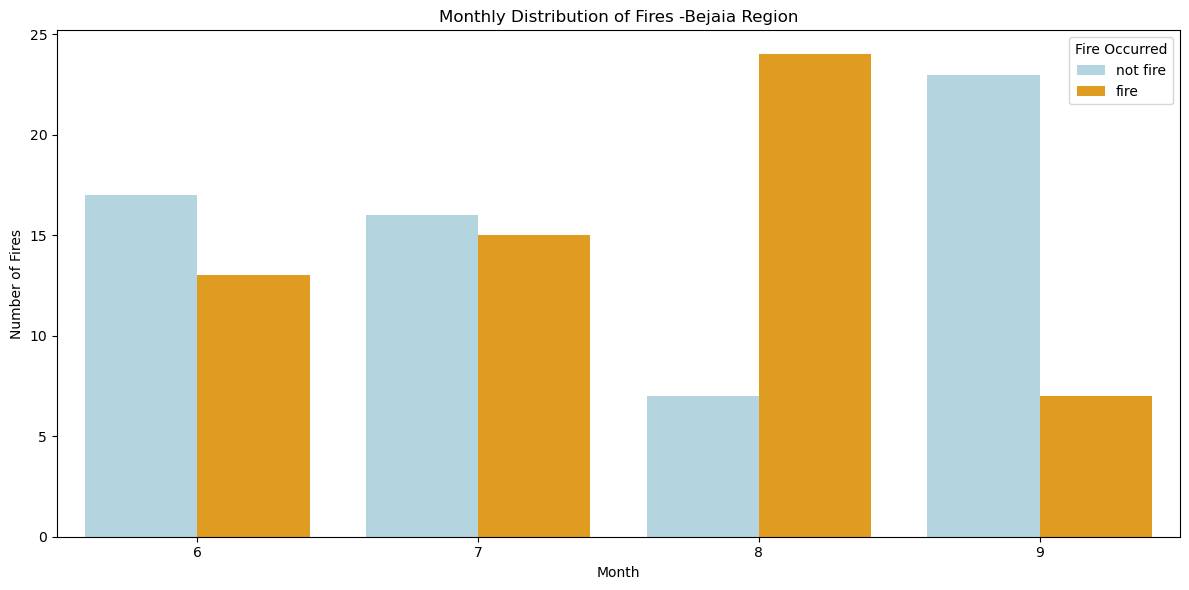

In [4]:
df.columns = df.columns.str.strip()


df['Classes'] = df['Classes'].str.strip()


df['month'] = df['month'].astype(str)

month_order = [str(i) for i in range(6,10)]


plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x='month',
    hue='Classes',
    order=month_order,
    palette={'fire': 'orange', 'not fire': 'lightblue'}
)

plt.title("Monthly Distribution of Fires -Bejaia Region")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.legend(title='Fire Occurred')
plt.tight_layout()
plt.show()
#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference : https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

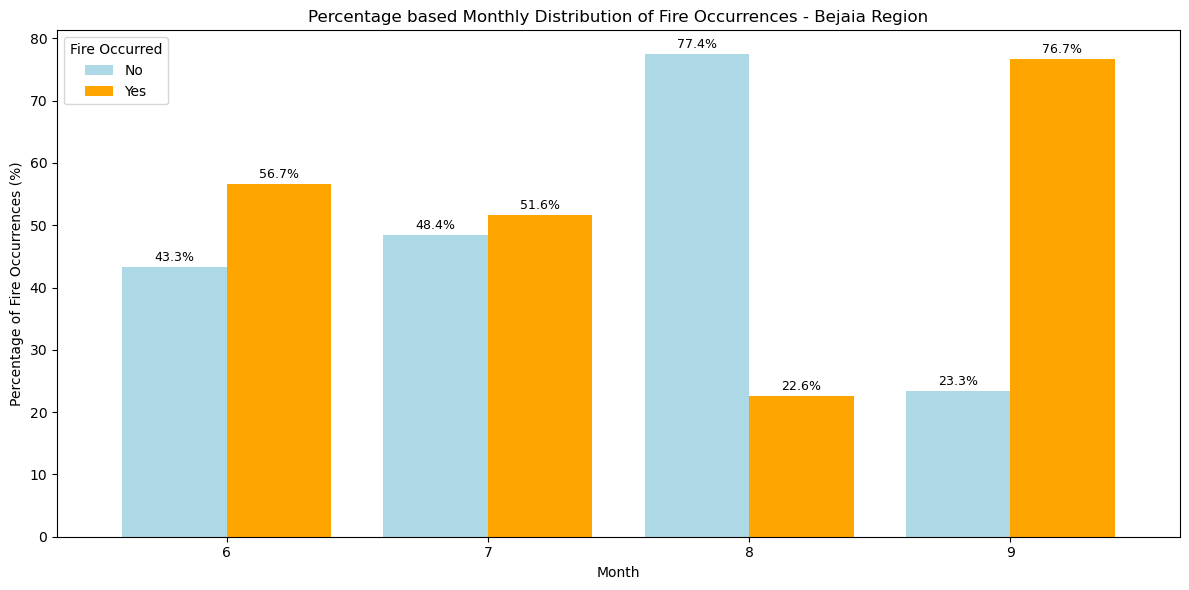

In [5]:
month_order = [str(i) for i in range(6, 10)]

df['month'] = df['month'].astype(str)
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['Classes'] = df['Classes'].str.strip().str.lower()

fire_recorded = df.groupby(['month', 'Classes'], observed=True).size().unstack(fill_value=0)
fire_occurred_percentage = fire_recorded.div(fire_recorded.sum(axis=1), axis=0) * 100

ax = fire_occurred_percentage.plot(
    kind='bar',
    color=['lightblue', 'orange'],
    figsize=(12,6),\
    width=0.8
)

plt.title("Percentage based Monthly Distribution of Fire Occurrences - Bejaia Region")
plt.xlabel("Month")
plt.ylabel("Percentage of Fire Occurrences (%)")
plt.legend(title='Fire Occurred', labels=['No','Yes'])
plt.xticks(rotation=0)
plt.tight_layout()

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() + 0.5,
        f'{p.get_height():.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()



#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference: https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

Correlation Heat Map 

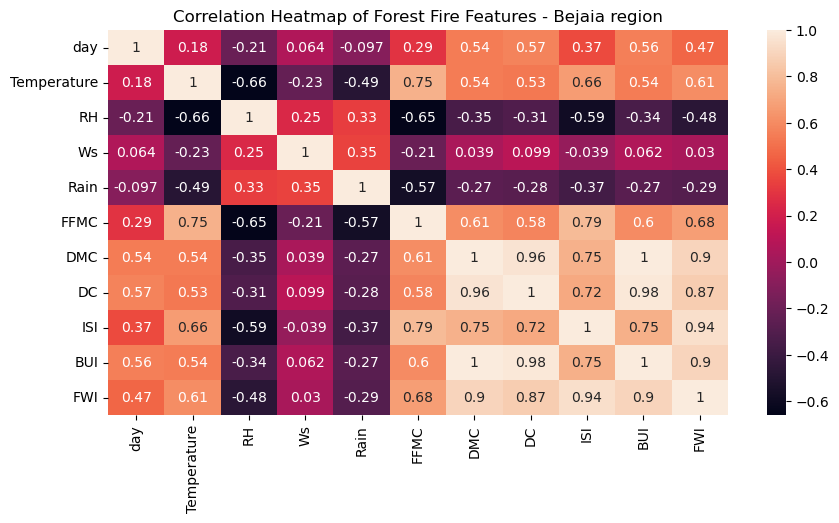

In [6]:
#plots the correlation heatmap - original 

corr_df = df.select_dtypes(include=[float, int]).drop(columns=['year'])

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
)
plt.title("Correlation Heatmap of Forest Fire Features - Bejaia region")
plt.show()
#reference: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/
#reference: https://www.geeksforgeeks.org/python/how-to-create-a-seaborn-correlation-heatmap-in-python/

Handling of Catergorical Values 

In [7]:
#uses label encoding to map catergorical features to its respective numerical values for month, day, season, fire_occurred

Classes_map = {'fire':1, 'not fire':0}

df['Classes'] = df['Classes'].map(Classes_map)

#reference: https://pandas.pydata.org/docs/dev/reference/api/pandas.Categorical.map.html

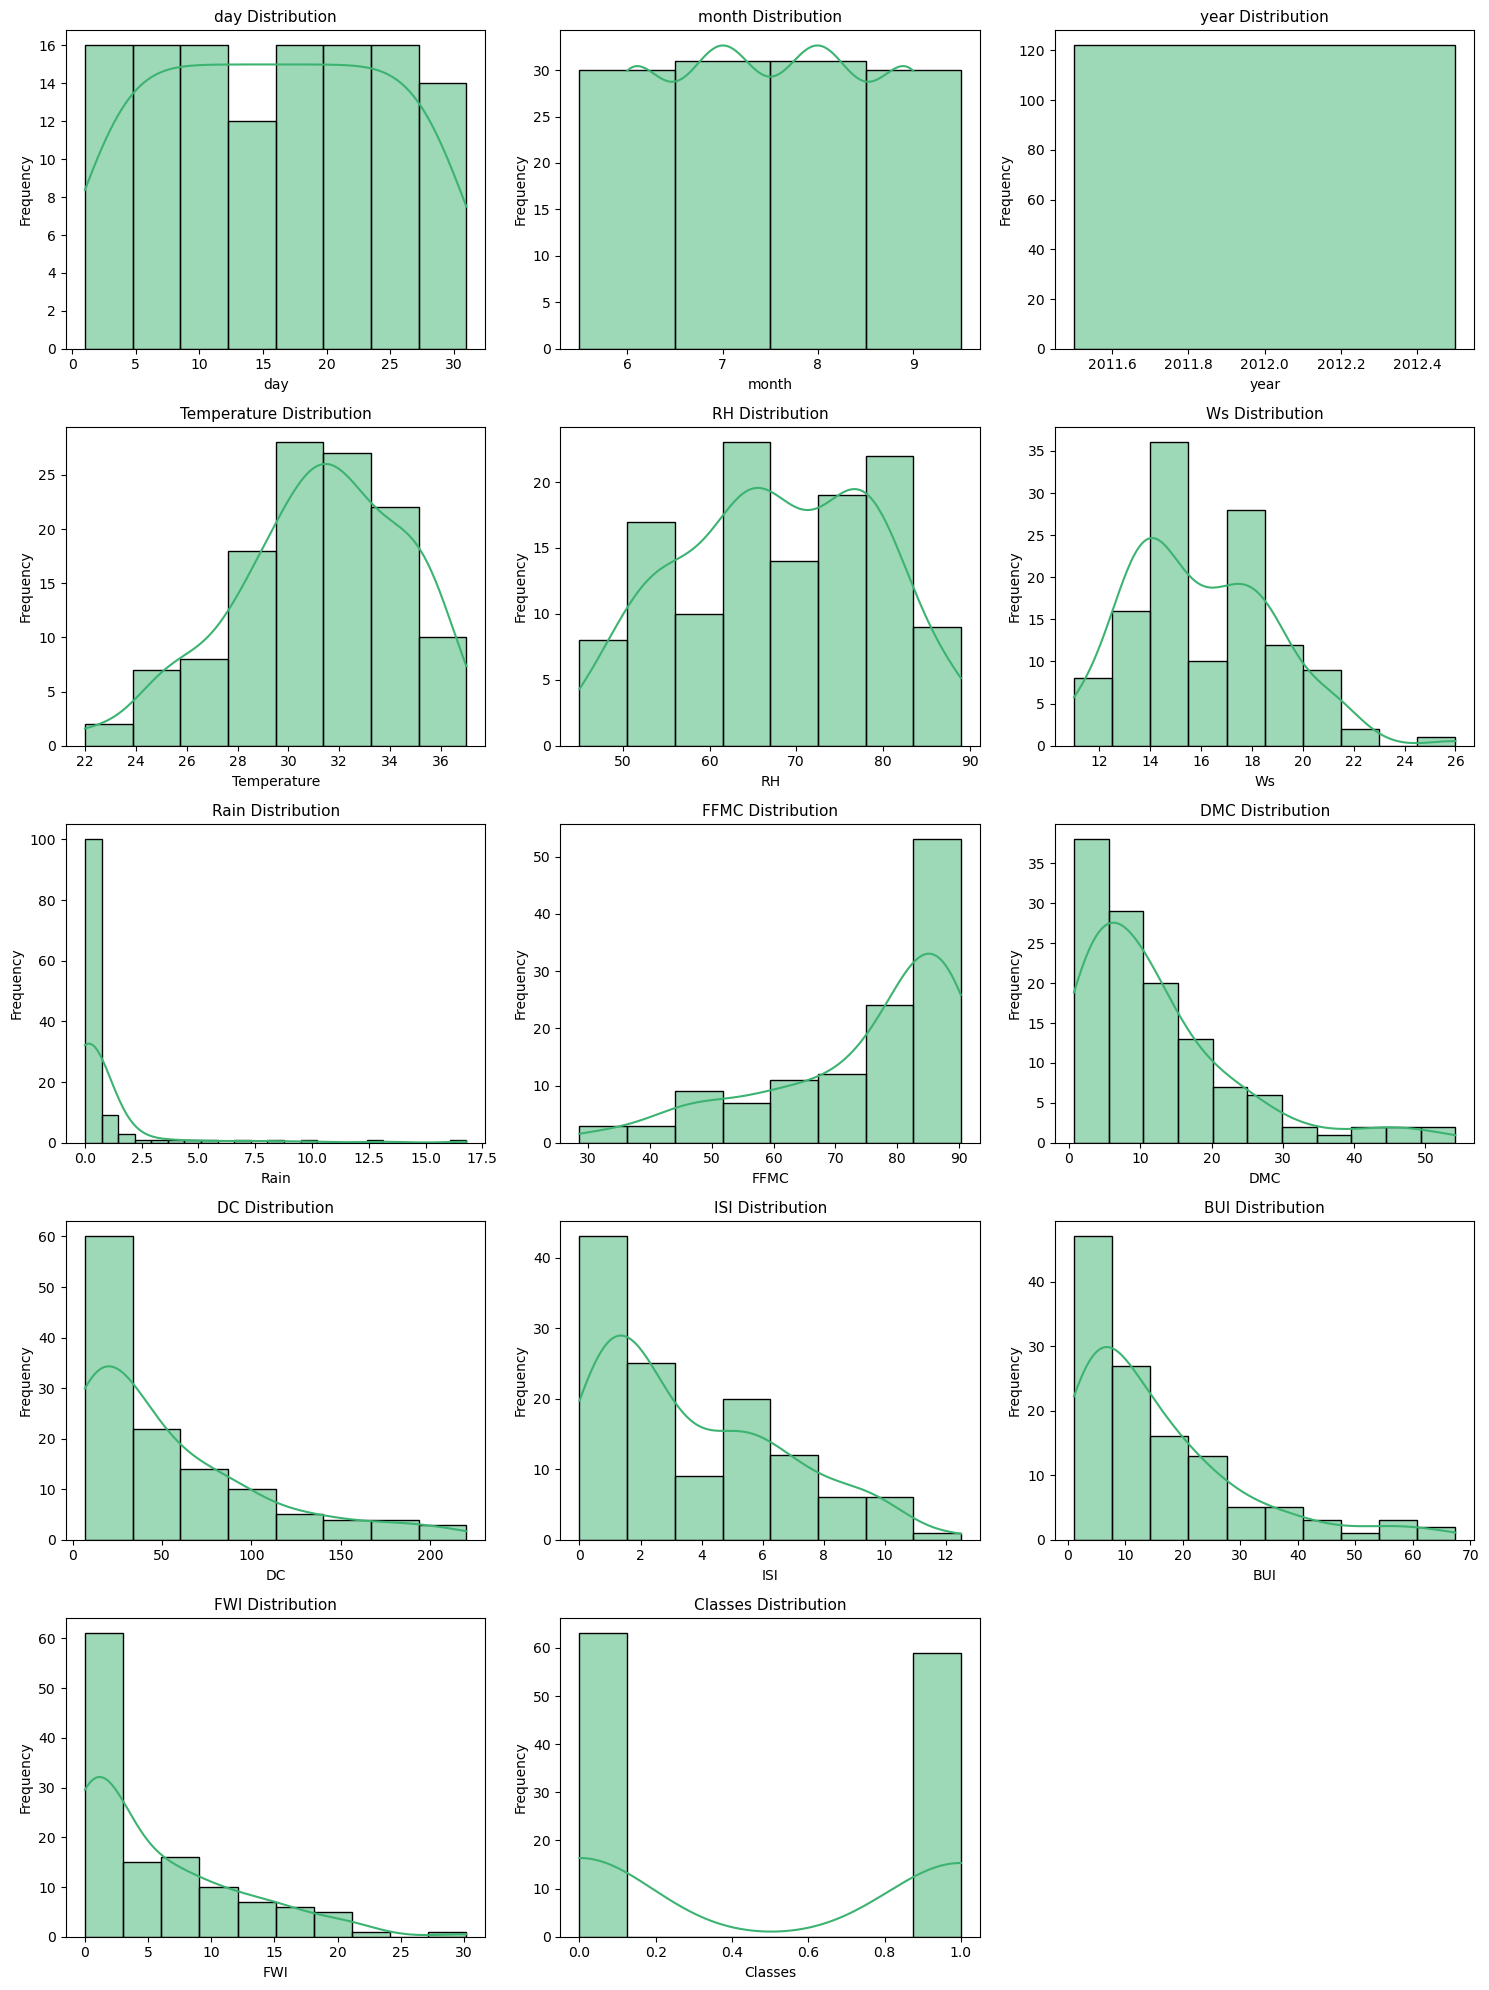

In [8]:

variables = df.columns #all columns in the dataset is used for distribution plotting
cols = 3  #sets the number of plots per row for the figure layout
rows = math.ceil(len(variables) / cols) #calculates the now of rows needed for the figure layout

plt.figure(figsize=(5*cols, 4*rows)) #sets the figure size based on the total number of rows and columns needed

for i, col in enumerate(variables, 1): #iterates thrugh each column 
    plt.subplot(rows, cols, i) #creates a subplot for each column 
    sns.histplot(df[col], kde=True, color='mediumseagreen', edgecolor='black') 
    plt.title(f'{col} Distribution', fontsize=11) #sets the title for each subplot
    plt.xlabel(col) #sets the x-axis label as the column name for each subplot
    plt.ylabel('Frequency') #sets the y-axis label as the frequency for each subplot 

plt.tight_layout()
plt.show()

#reference: https://www.w3schools.com/c/ref_math_ceil.php
#reference: https://www.w3schools.com/python/ref_func_enumerate.asp
#reference: https://www.statology.org/matplotlib-distribution-plot/

**Feature Scaling**

In [9]:
features = df.columns.drop('FWI') #all columns excepts FWI is used as the input features
target = 'FWI' #target variable is set as FWI

X = df[features]
y = df[target]

scaler = StandardScaler()  #standard scaler is used for feature scaling (z-score normalisation)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Summary after feature scaling:") #the statistical summary is displayed after feature scaling
print(X_scaled.describe().round(2))


Summary after feature scaling:
          day   month   year  Temperature      RH      Ws    Rain    FFMC  \
count  122.00  122.00  122.0       122.00  122.00  122.00  122.00  122.00   
mean     0.00    0.00    0.0         0.00   -0.00    0.00    0.00   -0.00   
std      1.00    1.00    0.0         1.00    1.00    1.00    1.00    1.00   
min     -1.68   -1.35    0.0        -2.78   -2.07   -1.76   -0.35   -2.97   
25%     -0.88   -0.45    0.0        -0.66   -0.72   -0.70   -0.35   -0.56   
50%      0.03    0.00    0.0        -0.05    0.00    0.00   -0.35    0.40   
75%      0.82    0.45    0.0         0.85    0.88    0.70   -0.14    0.78   
max      1.73    1.35    0.0         1.76    1.89    3.52    6.65    1.01   

          DMC      DC     ISI     BUI  Classes  
count  122.00  122.00  122.00  122.00   122.00  
mean    -0.00    0.00    0.00    0.00     0.00  
std      1.00    1.00    1.00    1.00     1.00  
min     -1.03   -0.90   -1.21   -0.99    -0.97  
25%     -0.77   -0.84   -0.84 

Box plot visualisation 

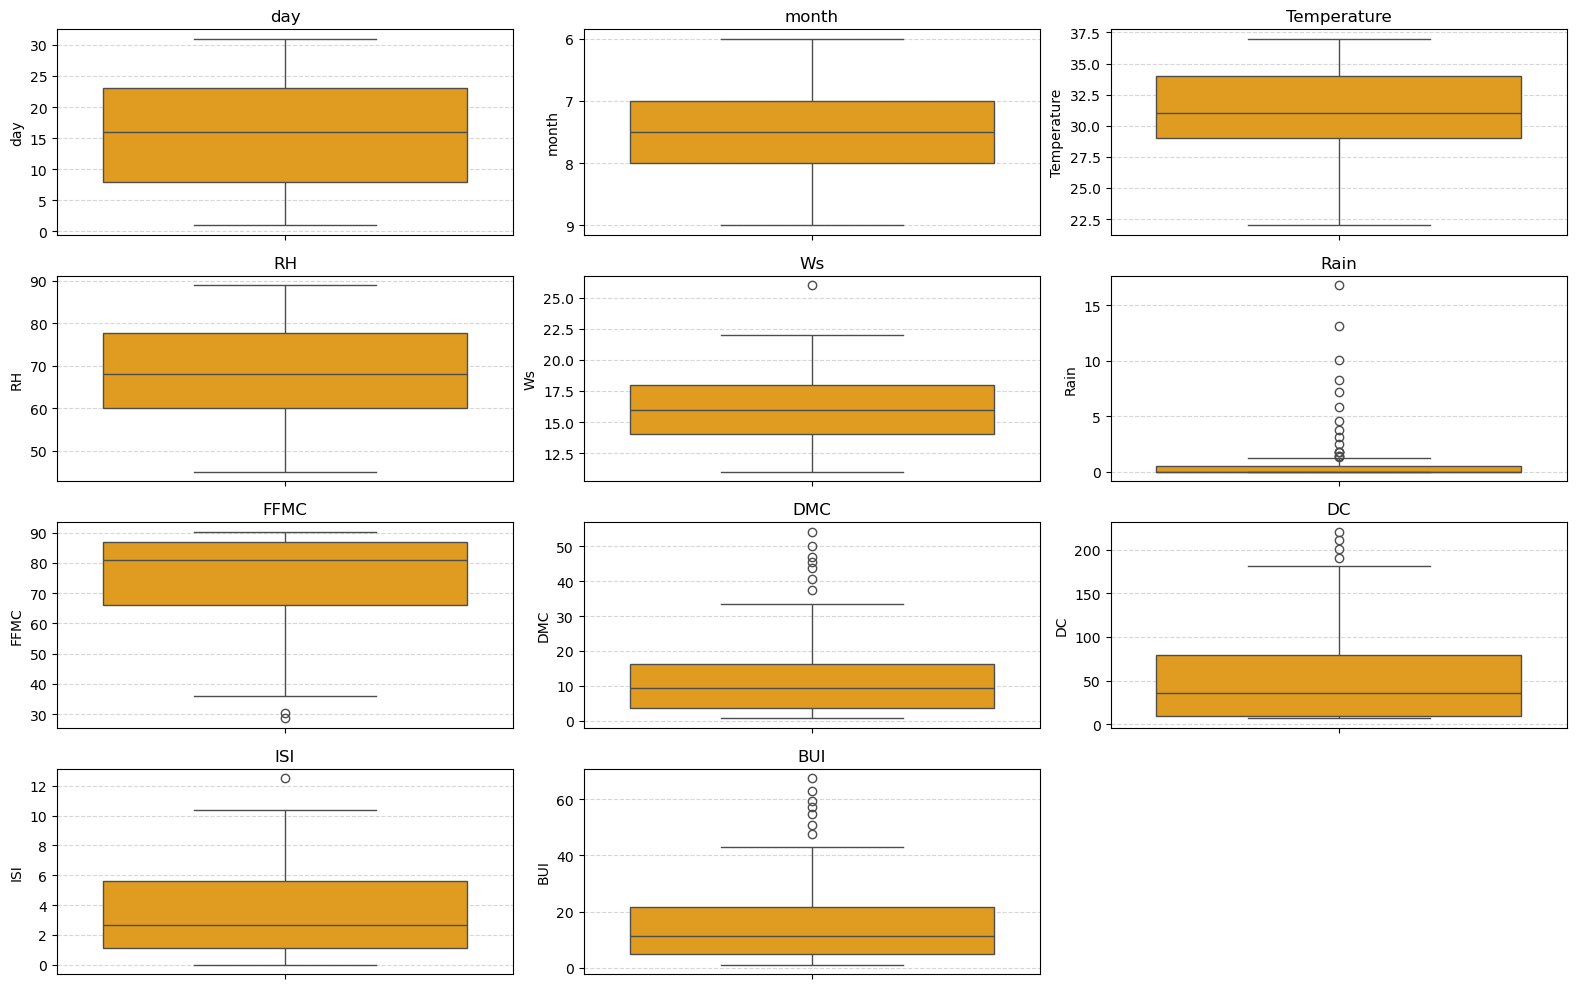

In [10]:

#box plot visualisation of the features after feature scaling
features = ["day", "month",	"Temperature","RH","Ws","Rain", "FFMC","DMC","DC","ISI","BUI"] #only the most relevant features are plotted (research is based on weather data and fire indices)

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)      #creates a subplot for each feature and includes it in a 3 by 3 grid layout
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

Handling of Outliers

Original dataset size: 122
Dataset size after capping outliers: 122


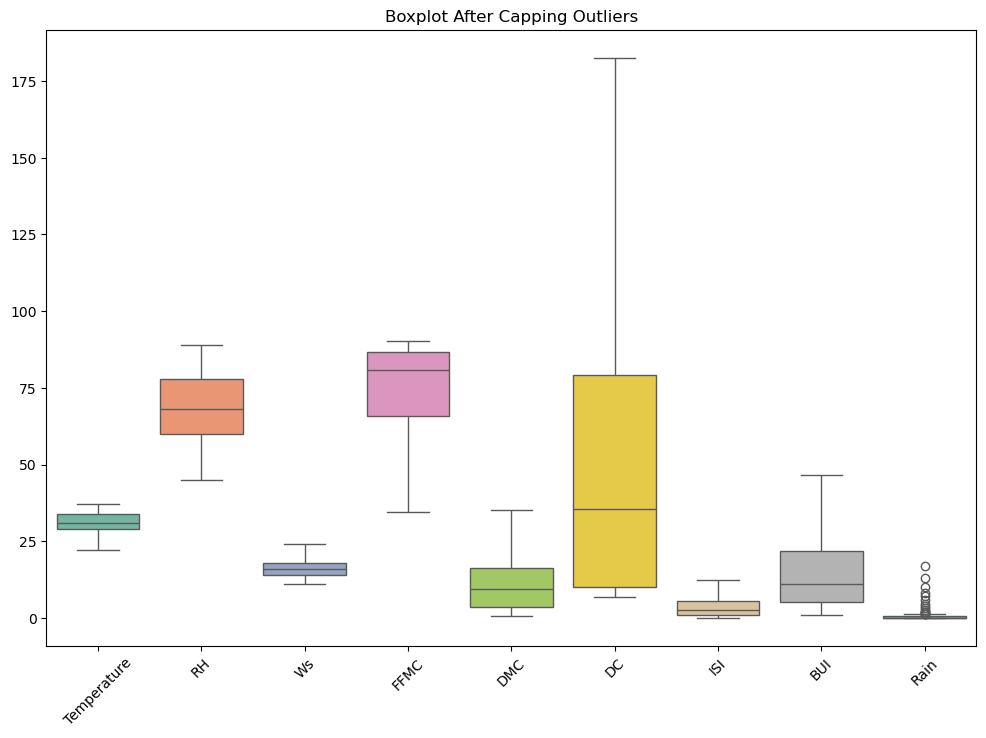

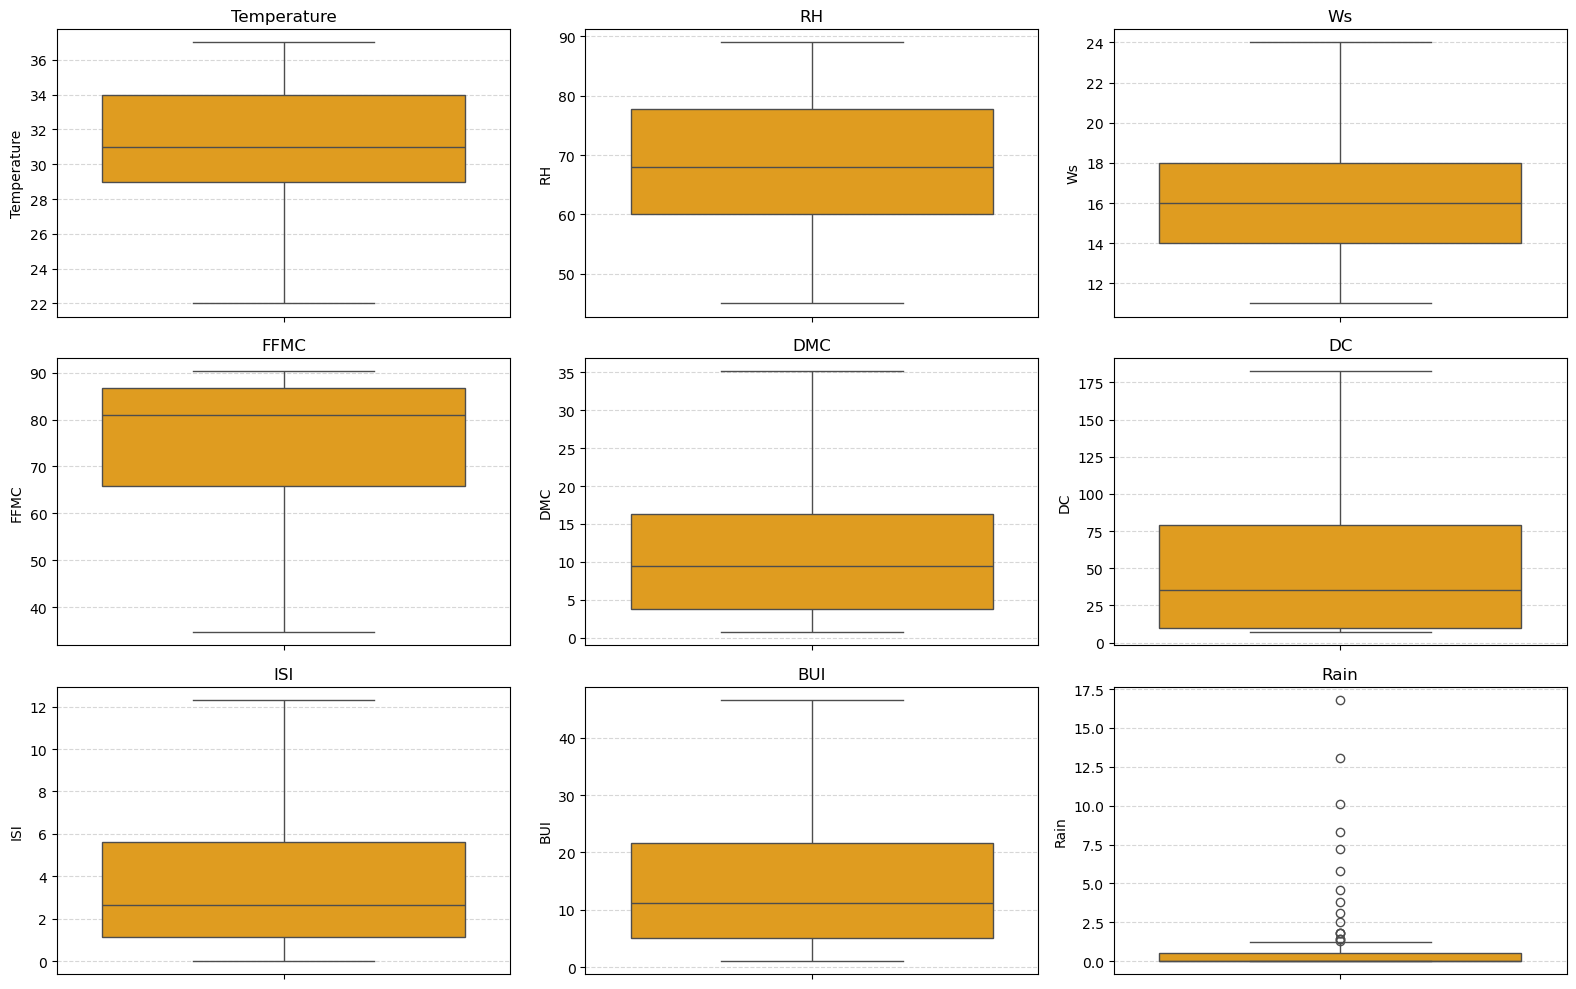

In [11]:

# following fuction is used to limit extreme values using IQR method
def cap_outliers(df, columns, factor=1.5): # k = 1.5 
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df[col] = np.clip(df[col], lower, upper) #caps/replaces values outside the lower and upper bounds 
    return df

features =  ["Temperature","RH","Ws", "FFMC","DMC","DC","ISI","BUI"] #most relavant features (numerical) for the FWI is used 

df = cap_outliers(df, features) #caps the outliers using the preivously defined function (cap_outliers)

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after capping outliers: {df.shape[0]}")  # prints the size of the dataset after capping outliers to ensure the size is unchanged


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features +['Rain']]) #features scales the capped dataset

#plots boxplots to visualise the capped outliers and ensure no outliers are present
plt.figure(figsize=(12,8))
sns.boxplot(data=df[features+['Rain']], palette="Set2")
plt.title("Boxplot After Capping Outliers")
plt.xticks(rotation=45)
plt.show()

# plots individual boxplots for a better visualisation of each feature in a 3 by 3 grid layout (easier to compare with the previous boxplot before capping)
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features+['Rain'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
#reference: https://www.geeksforgeeks.org/data-visualization/box-plot-in-python-using-matplotlib/
#reference: https://stackoverflow.com/questions/42207920/how-to-take-floor-and-capping-for-removing-outliers
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

**Feature Importance**

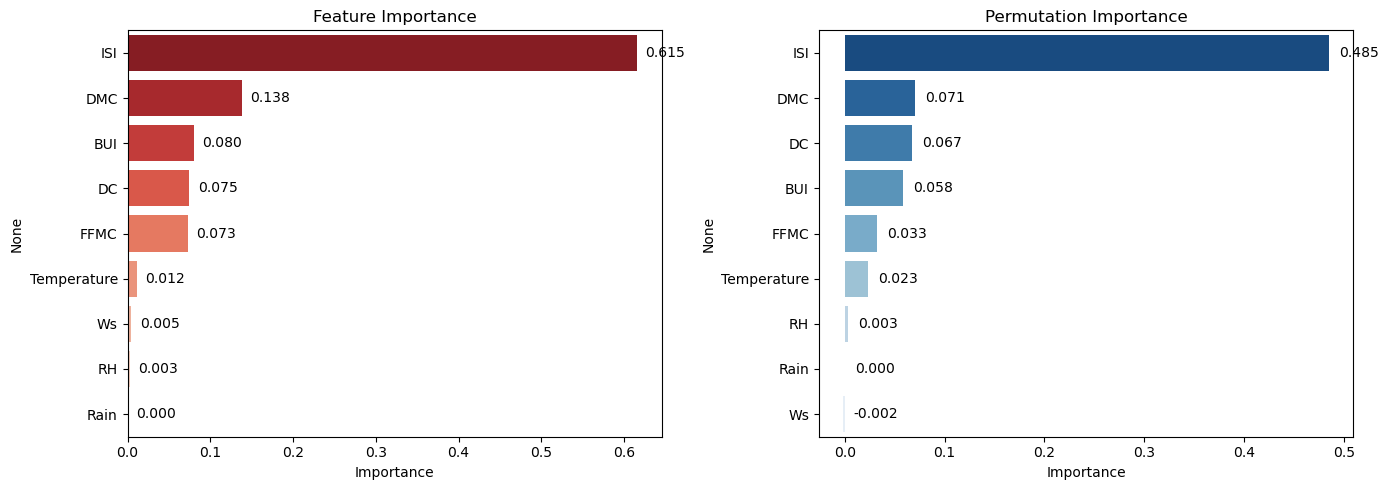

Feature Importance Comparison:
             Built-in  Permutation
BUI             0.080        0.058
DC              0.075        0.067
DMC             0.138        0.071
FFMC            0.073        0.033
ISI             0.615        0.485
RH              0.003        0.003
Rain            0.000        0.000
Temperature     0.012        0.023
Ws              0.005       -0.002


In [12]:

features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"] #same most relevant features as before is used 
target = 'FWI'

X = df[features] #capped dataset is used for training the RF model 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #data is split into 80% training and 20% testing

model = RandomForestRegressor(n_estimators=100, random_state=42) #random forest regressor model is used with 100 trees/estimators 
model.fit(X_train, y_train)

#mdi feature importance and permutation feature importance are calculated
mdi_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False) #built-in feature importance from the random forest model 
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) 
perm_importances = pd.Series(perm_result.importances_mean, index=features).sort_values(ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for MDI - built-in feature importance
sns.barplot(x=mdi_importances.values, y=mdi_importances.index, hue=mdi_importances.index, 
            palette='Reds_r', ax=axes[0], legend=False)
axes[0].set_title('Feature Importance')
axes[0].set_xlabel('Importance')

for i, v in enumerate(mdi_importances.values): #values for each bar is added on the barplot
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# Plot 2 for the permutation feature importance
sns.barplot(x=perm_importances.values, y=perm_importances.index, hue=perm_importances.index,
            palette='Blues_r', ax=axes[1], legend=False)
axes[1].set_title('Permutation Importance')
axes[1].set_xlabel('Importance')

for i, v in enumerate(perm_importances.values): #values for each bar is added on the barplot
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

#feature comparison table is printed 
print("Feature Importance Comparison:")
print(pd.DataFrame({'Built-in': mdi_importances, 'Permutation': perm_importances}).round(3))

#reference: https://www.geeksforgeeks.org/machine-learning/feature-importance-with-random-forests/ (built-in feature importance)
#reference: https://scikit-learn.org/stable/modules/permutation_importance.html
#reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Pearson Correlation 

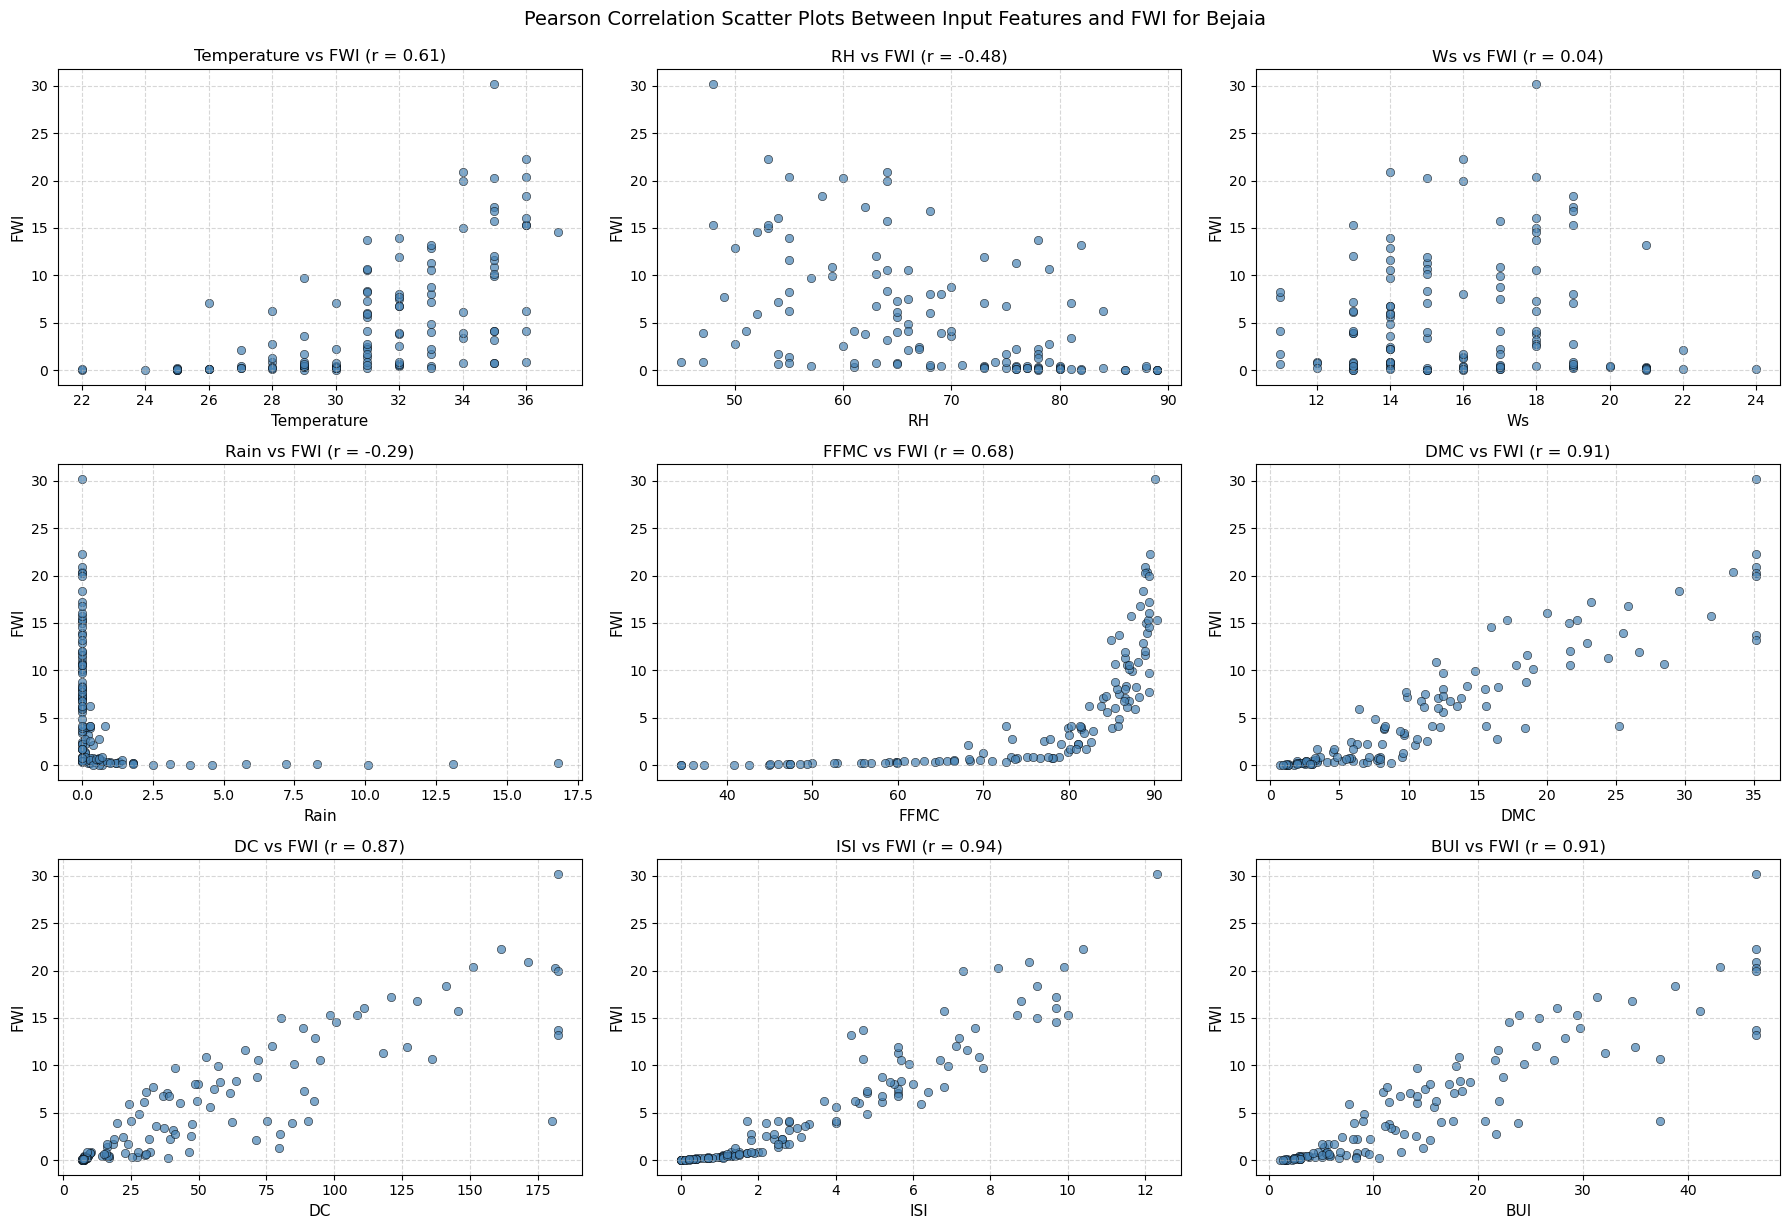

Pearson correlation coefficients for features and FWI:
Temperature: 0.608
RH: -0.476
Ws: 0.035
Rain: -0.293
FFMC: 0.681
DMC: 0.912
DC: 0.867
ISI: 0.943
BUI: 0.907


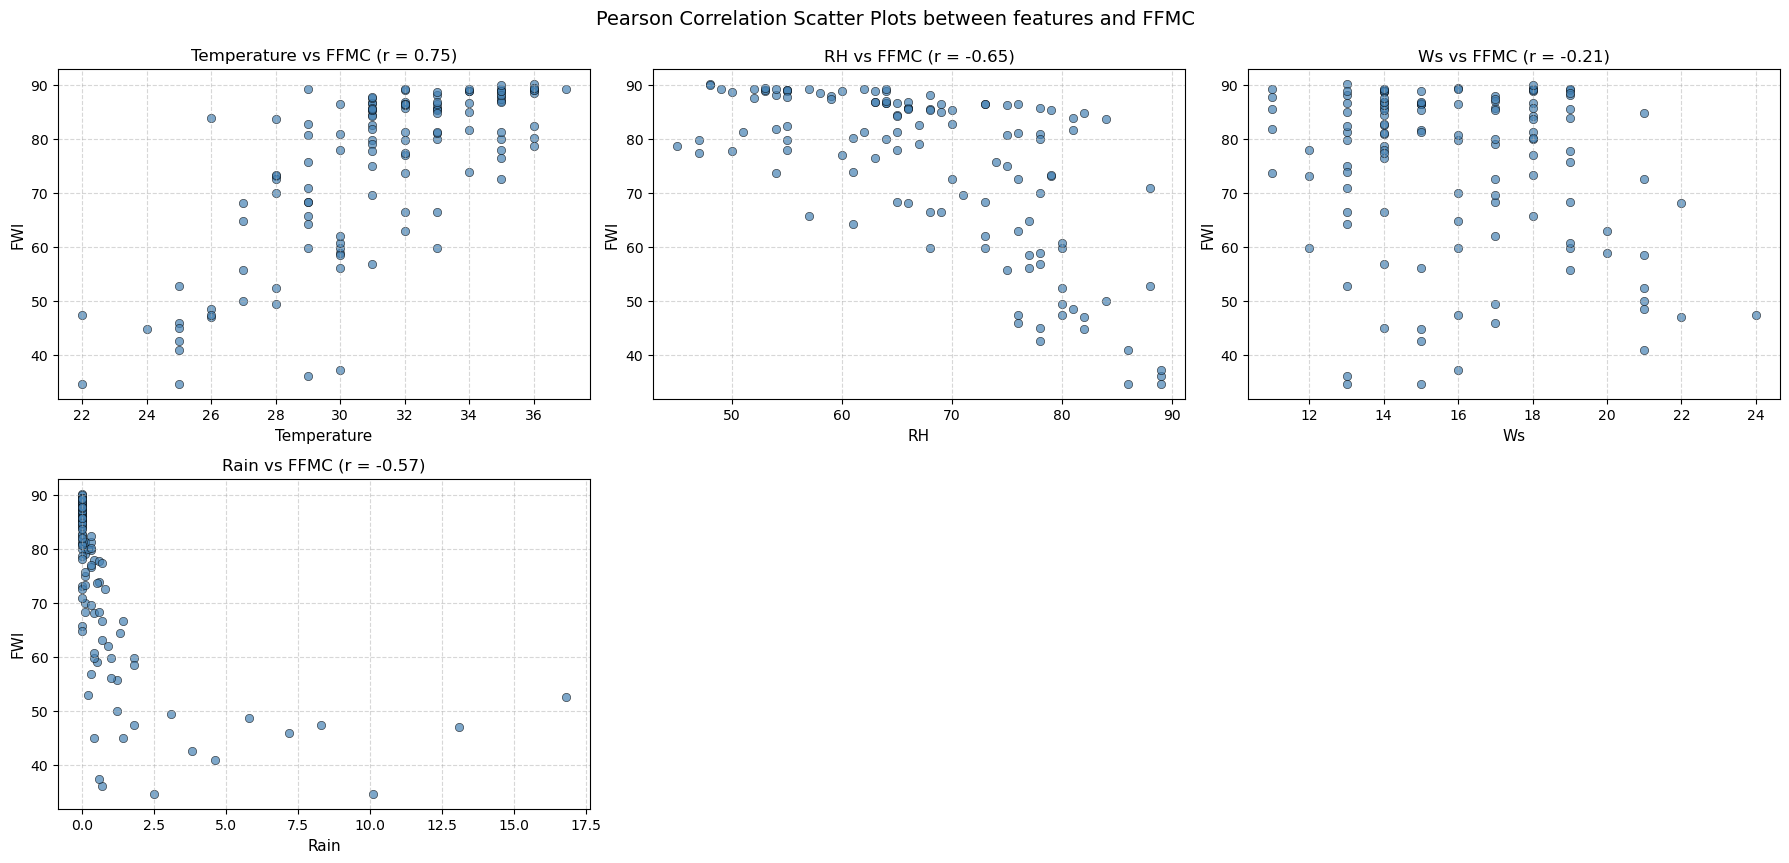

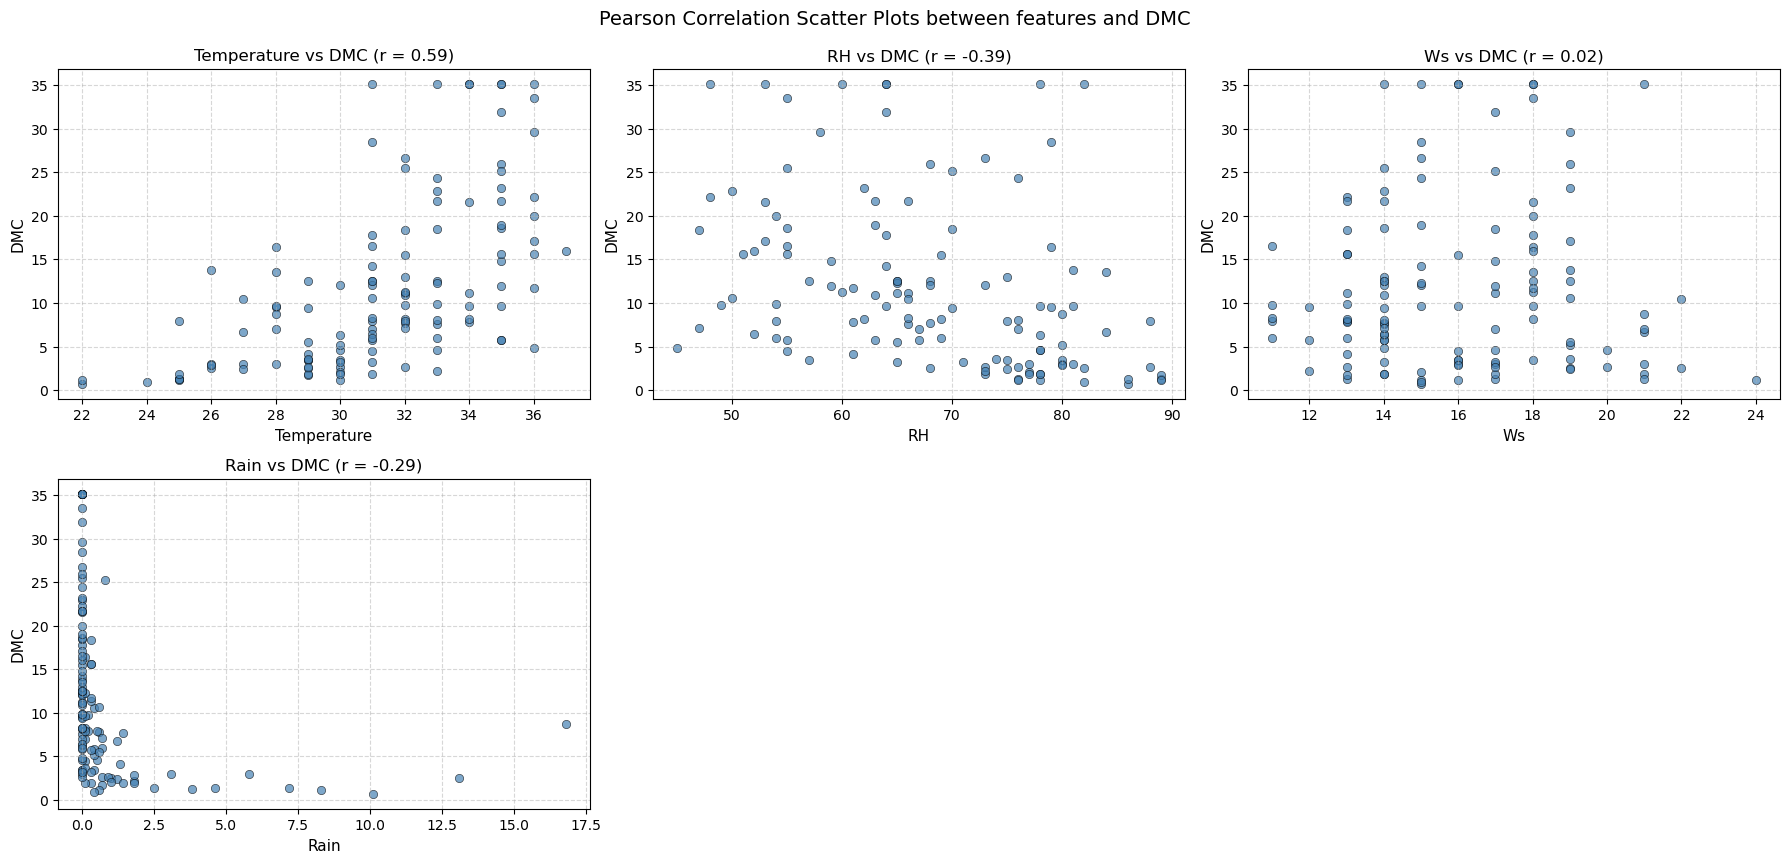

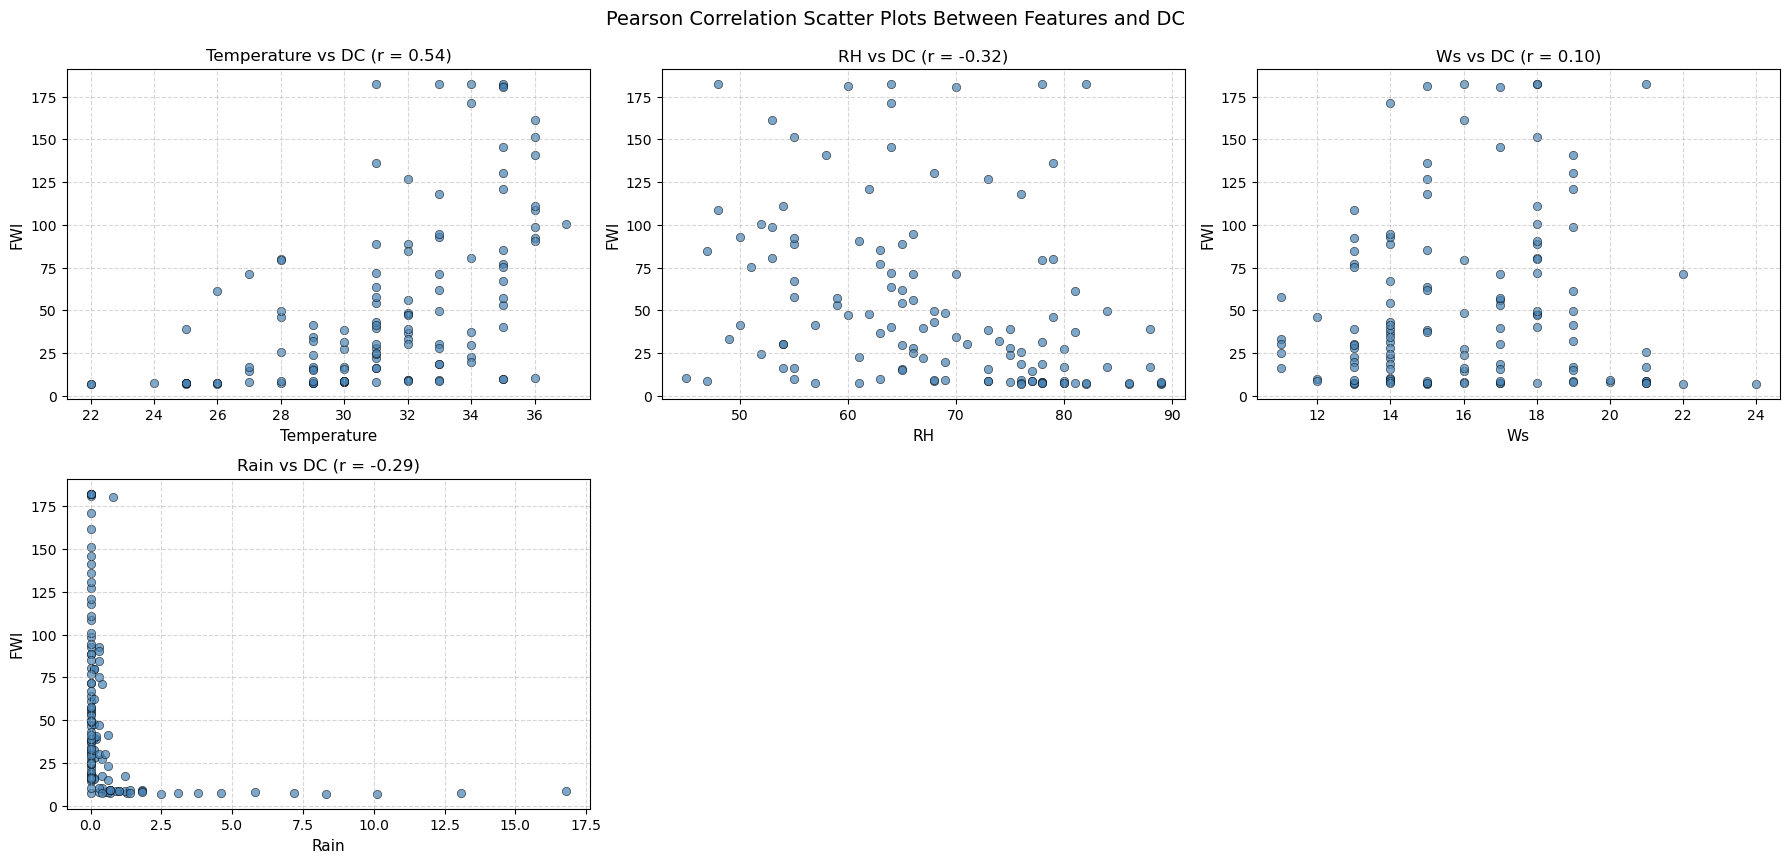

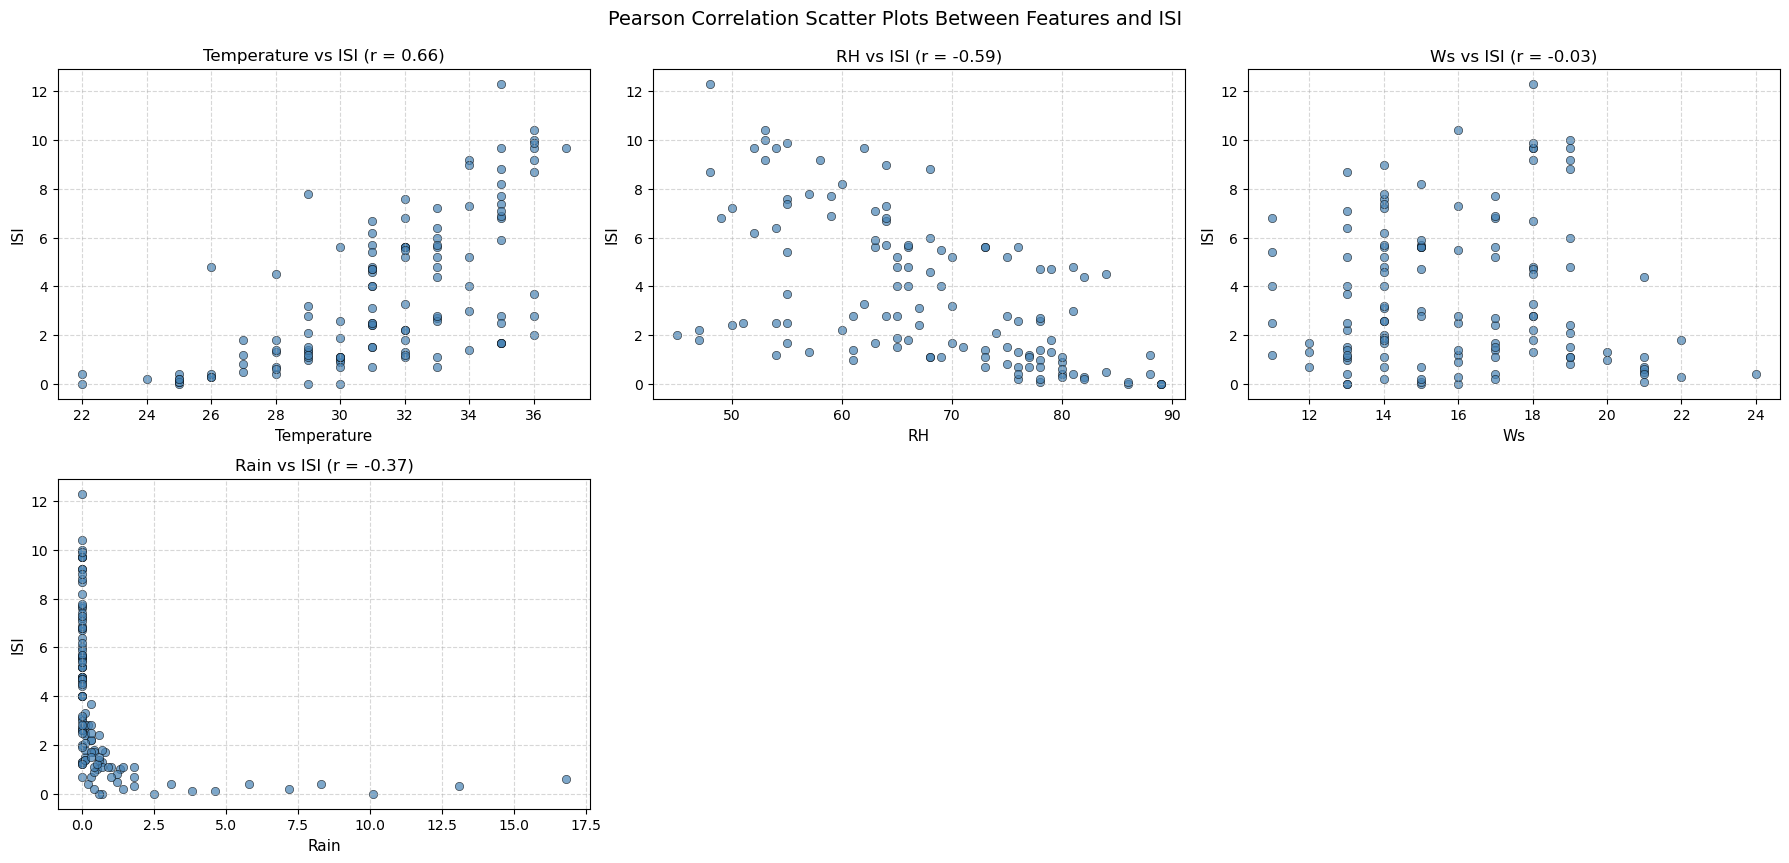

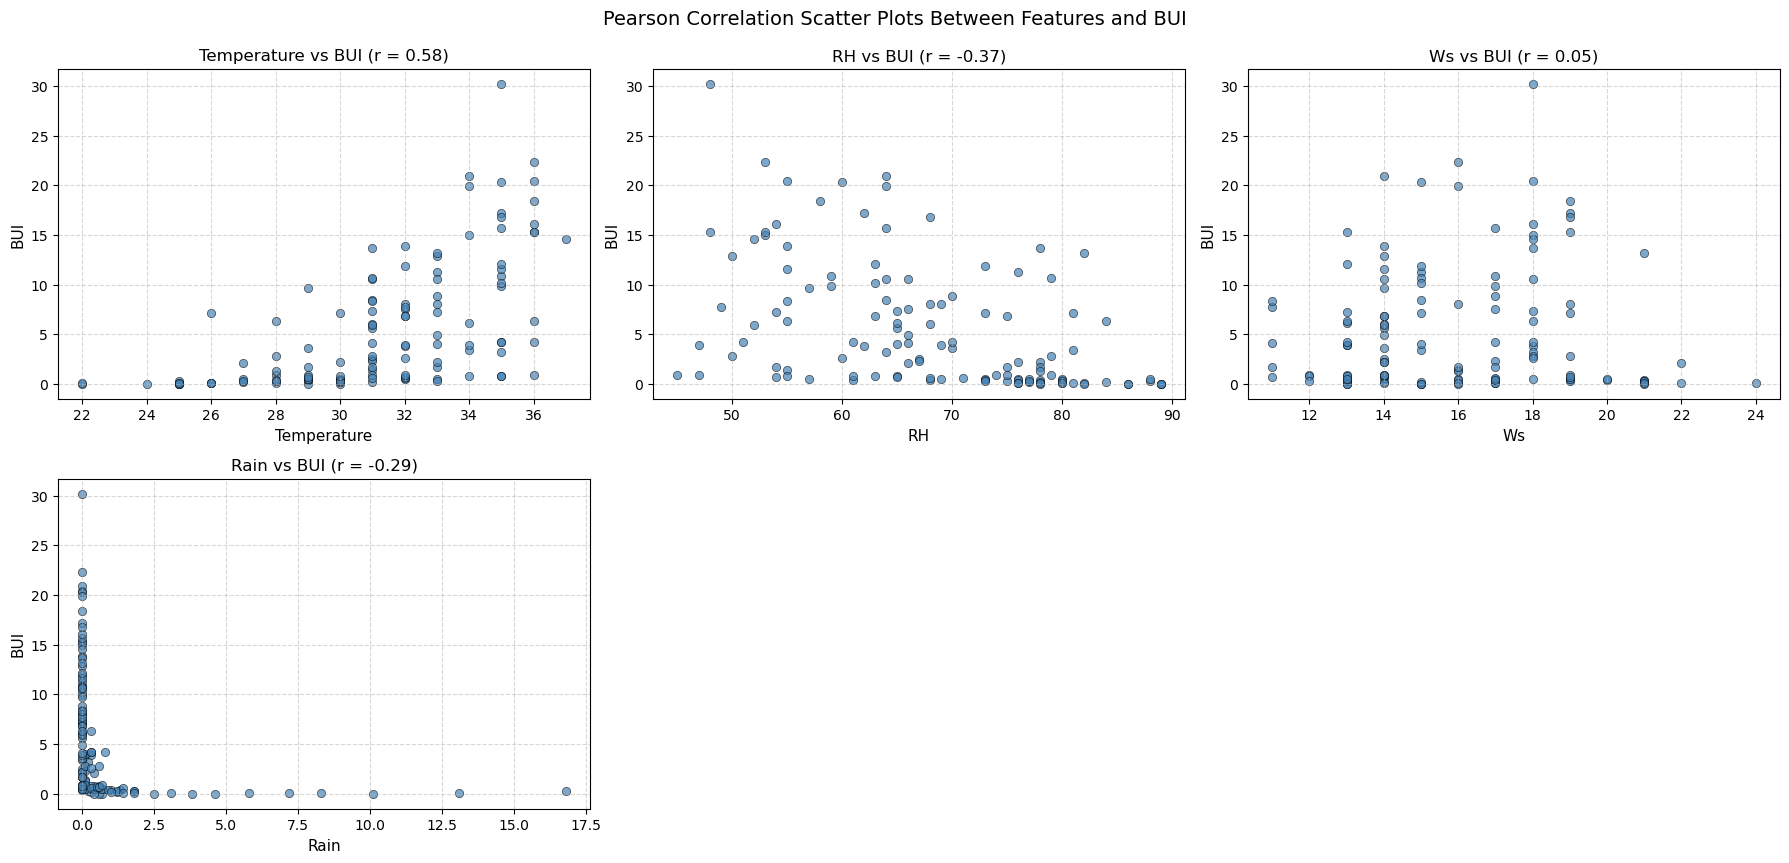

In [13]:
X = df[features]               
y = df['FWI']         

#applying pearson correlation matrix
def covariance(X, y):
    if len(X) != len(y):
       raise ValueError("X and Y must be the same length !")
    x_mean = np.mean(X)
    y_mean = np.mean(y)
    return sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(len(X))) / len(X)

def pearson_correlation(X, y):
    cov = covariance(X, y)
    std_dev_x = np.std(X)
    std_dev_y = np.std(y)
    if std_dev_x == 0 or std_dev_y == 0:
        return np.nan  # No correlation possible
    return cov / (std_dev_x * std_dev_y)

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[feature]) == 0 or np.std(df['FWI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['FWI'])[0, 1]

    plt.title(f'{feature} vs FWI (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Input Features and FWI for Bejaia", fontsize=14, y=1.02)
plt.show()

correlations = {}
for col in X.columns:
    correlations[col] = pearson_correlation(X[col].values, y.values)

print("Pearson correlation coefficients for features and FWI:")
for feature, r in correlations.items():
    print(f"{feature}: {r:.3f}")

#Pearson correlation for FFMC
weather_features = ["Temperature","RH","Ws","Rain"]
X = df[weather_features]               
y = df['FFMC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['FFMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['FFMC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['FFMC'])[0, 1]

    plt.title(f'{weather_feature} vs FFMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and FFMC", fontsize=14, y=1.02)
plt.show()

#Pearson correlation for DMC

X = df[weather_features]               
y = df['DMC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['DMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['DMC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['DMC'])[0, 1]

    plt.title(f'{weather_feature} vs DMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('DMC', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and DMC", fontsize=14, y=1.02)
plt.show()

#pearson correlation for DC

X = df[weather_features]               
y = df['DC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['DC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['DC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['DC'])[0, 1]

    plt.title(f'{weather_feature} vs DC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and DC", fontsize=14, y=1.02)
plt.show() 

#pearson correlation for ISI

X = df[weather_features]               
y = df['ISI']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['ISI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['ISI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['ISI'])[0, 1]

    plt.title(f'{weather_feature} vs ISI (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('ISI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and ISI", fontsize=14, y=1.02)
plt.show()

#pearson correlation for BUI

X = df[weather_features]               
y = df['BUI']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['BUI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['BUI'])[0, 1]

    plt.title(f'{weather_feature} vs BUI (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('BUI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and BUI", fontsize=14, y=1.02)
plt.show()


#reference: https://medium.com/@shivogojohn/pearson-correlation-coefficient-in-python-74fb569f2b7f

**Model Development**

Model 1 - using all input features 

[I 2025-11-04 21:54:56,960] A new study created in memory with name: no-name-8bb6cb8f-48da-46af-ac92-833251c4396e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 21:54:57,004] Trial 0 finished with value: 0.66993277766392 and parameters: {'learning_rate': 0.13793411273511916, 'max_depth': 8, 'subsample': 0.7364178350882042, 'colsample_bytree': 0.903378519327277, 'lambda': 0.7517914465976309, 'alpha': 2.018019115768436}. Best is trial 0 with value: 0.66993277766392.
[I 2025-11-04 21:54:57,030] Trial 1 finished with value: 1.0921859962207388 and parameters: {'learning_rate': 0.027397565804793675, 'max_depth': 7, 'subsample': 0.7040711984268304, 'colsample_bytree': 0.5267847575920759, 'lambda': 0.31960891374483885, 'alpha': 3.5249961265490586}. Best is trial 0 with value: 0.66993277766392.
[I 2025-11-04 21:54:57,059] Trial 2 finished with value: 0.9776957644622346 and parameters: {'learning_rate': 0.2695696303031634, 'max_depth': 6, 'subsample': 0.5624011431044951, 'colsample_bytree': 0.7310990415165668, 'lambda': 2.0204665230427663, 'alpha': 0.9507640578488326}. Best is trial 0 with value: 0.66993277766392.
[I 2025-11-04 21:54:57,08

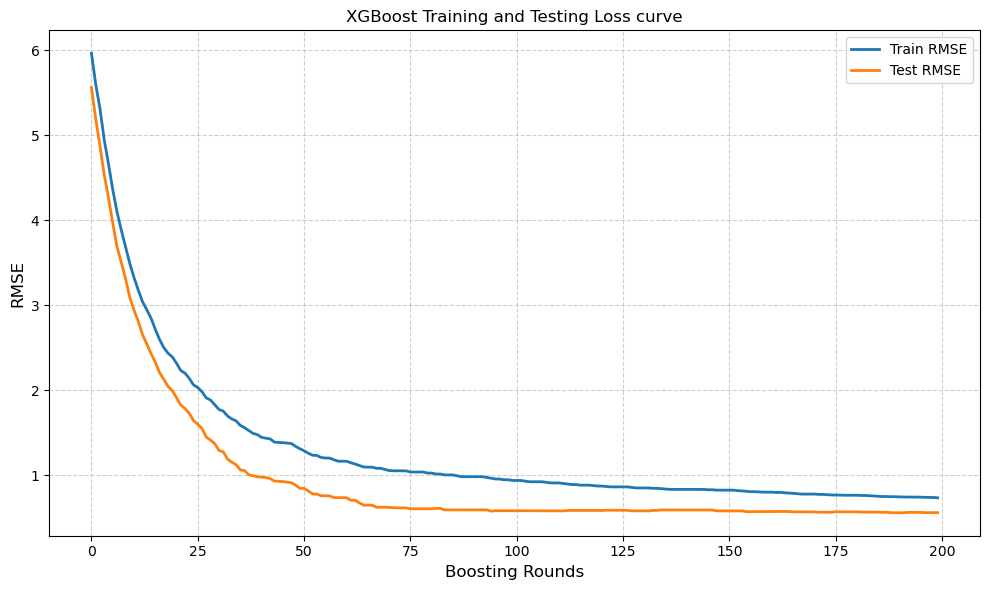

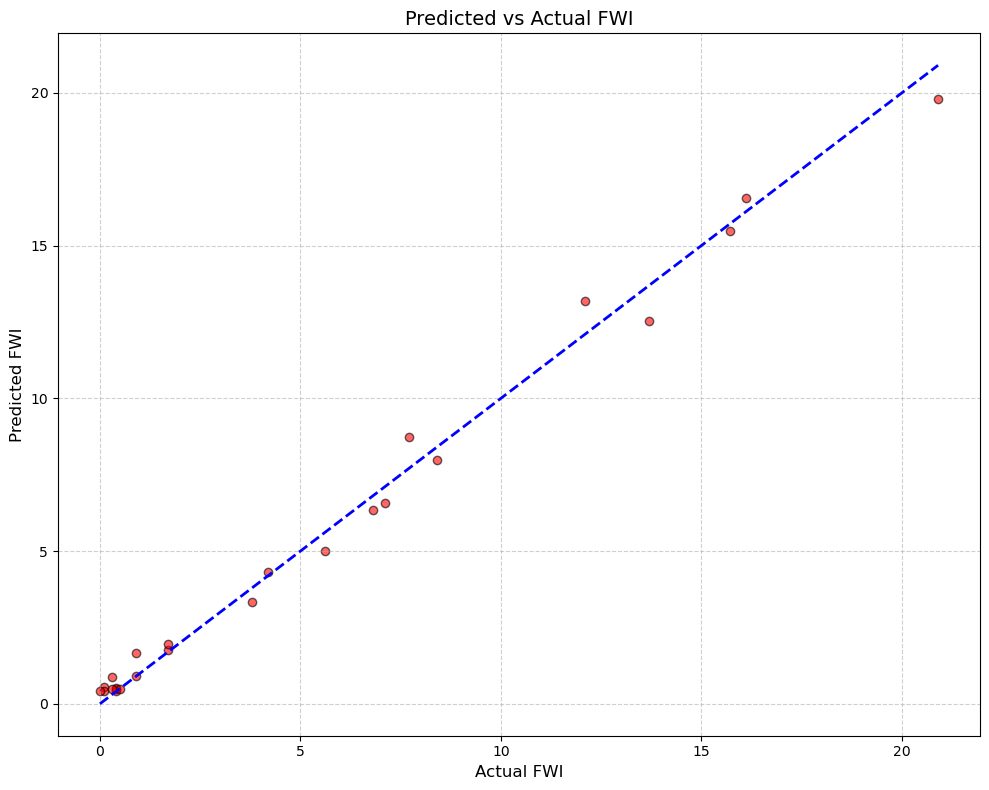

In [ ]:
features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"]
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 

xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial): #the hyperparameter tuning objective function is defined 
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100, #model is trained using the intially defined parameters
                      evals=[(xgb_test, 'test')],
                      verbose_eval=True)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)  #using optuna the best parameters are found 

#loss curve plotting
evals_result = {}
final_model = xgb.train(   #the final model is trained on the best parameters
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

preds = final_model.predict(xgb_test)   
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12) #loss curve is plotted
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2)  #Predicted VS Actual plot is plotted
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 


df_map = X_test.copy() 

df_map['FWI_pred'] = preds # Pivot table for heatmap
heatmap_data = df_map.pivot_table(index='Y', columns='X', values='FWI_pred', aggfunc='mean')

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Predicted FWI')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wildfire Risk Map (Predicted FWI)')
plt.show()

plt.scatter(df_map['X'], df_map['Y'], c=df_map['FWI_pred'], cmap='hot', edgecolor='k')
plt.colorbar(label='Predicted FWI')
plt.show() 

#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

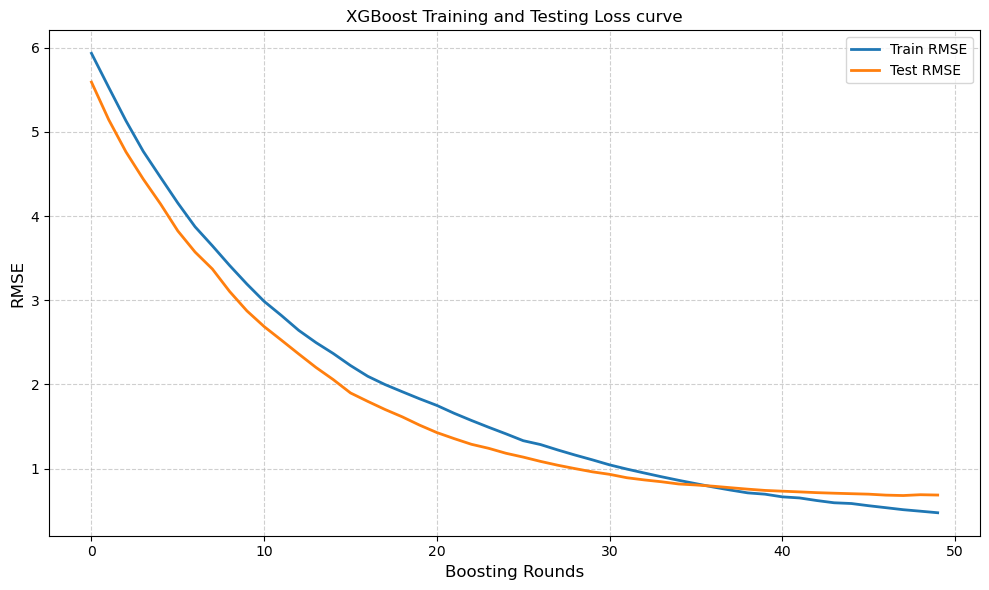

R² Score: 0.987
RMSE: 0.685
MAE: 0.461


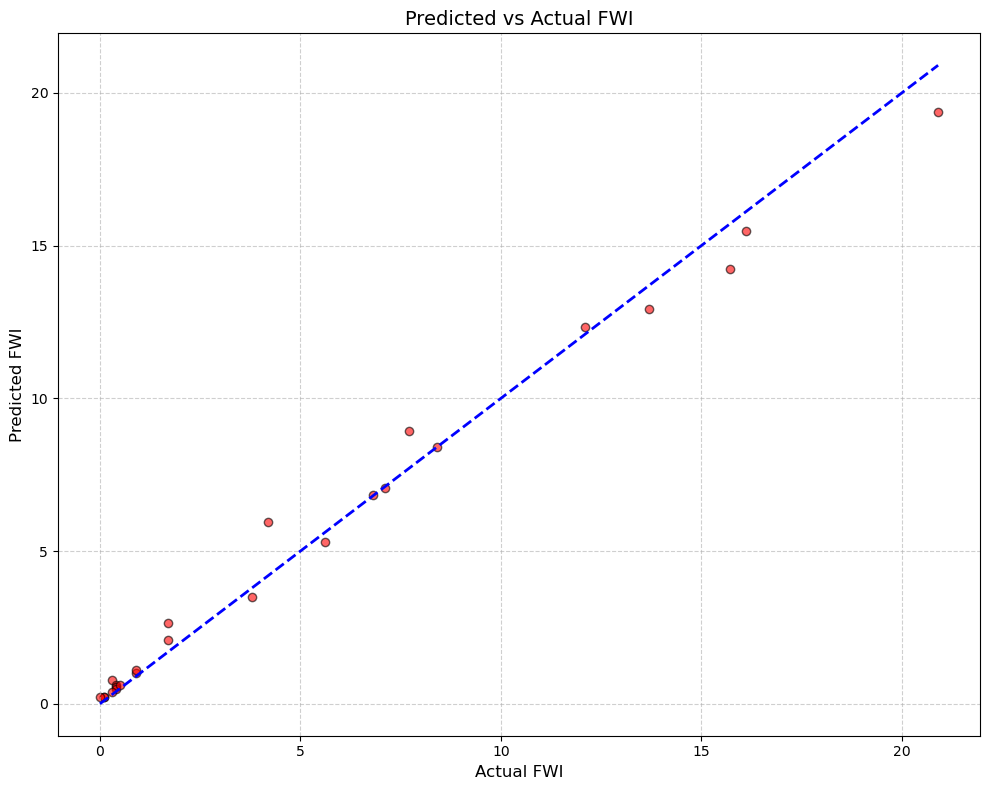

   day month  year  Temperature  RH  Ws  Rain   FFMC  DMC    DC  ISI  BUI  \
0    1     6  2012           29  57  18   0.0  65.70  3.4   7.6  1.3  3.4   
1    2     6  2012           29  61  13   1.3  64.40  4.1   7.6  1.0  3.9   
2    3     6  2012           26  82  22  13.1  47.10  2.5   7.1  0.3  2.7   
3    4     6  2012           25  89  13   2.5  34.65  1.3   6.9  0.0  1.7   
4    5     6  2012           27  77  16   0.0  64.80  3.0  14.2  1.2  3.9   

   FWI  Classes  
0  0.5        0  
1  0.4        0  
2  0.1        0  
3  0.0        0  
4  0.5        0   



In [15]:

features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"]
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.0835,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0.1,
    "seed": 42
}
n=50

evals_result = {}

model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n, evals=[(xgb_train, 'train'), (xgb_test, 'test')],evals_result=evals_result, verbose_eval=False)

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

preds = model.predict(xgb_test)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(df.head(), '\n') 


**Model 2 - Only weather data**

XGBoost

[I 2025-11-04 21:54:58,449] A new study created in memory with name: no-name-b349b368-da43-4531-a992-45a2918c7be3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 21:54:58,497] Trial 0 finished with value: 3.486282639760889 and parameters: {'learning_rate': 0.29077386796715293, 'max_depth': 3, 'subsample': 0.6438940421016592, 'colsample_bytree': 0.9461398033754448, 'lambda': 4.411602360888529, 'alpha': 1.992303803576331}. Best is trial 0 with value: 3.486282639760889.
[I 2025-11-04 21:54:58,531] Trial 1 finished with value: 4.005803286461356 and parameters: {'learning_rate': 0.20447565713475846, 'max_depth': 6, 'subsample': 0.9379295720032061, 'colsample_bytree': 0.8872743033588508, 'lambda': 0.1555773965590545, 'alpha': 0.866099862342336}. Best is trial 0 with value: 3.486282639760889.
[I 2025-11-04 21:54:58,554] Trial 2 finished with value: 3.609666598242454 and parameters: {'learning_rate': 0.2304911306064144, 'max_depth': 4, 'subsample': 0.9104243205915392, 'colsample_bytree': 0.7400839108238867, 'lambda': 3.215659099070805, 'alpha': 0.501829668990229}. Best is trial 0 with value: 3.486282639760889.
[I 2025-11-04 21:54:58,583] 

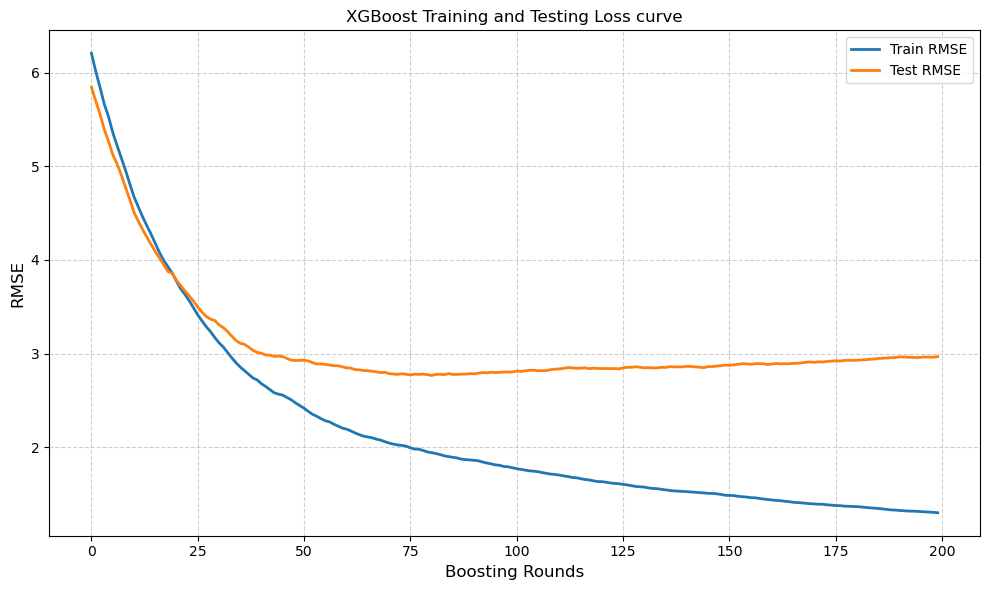

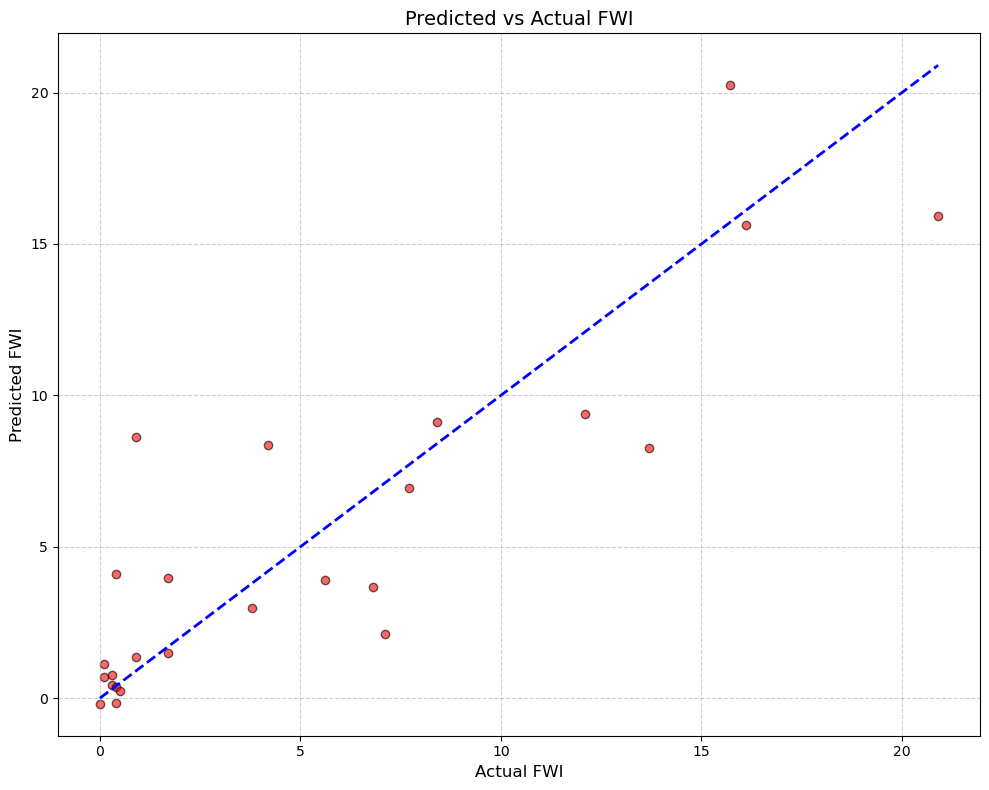

In [ ]:
features = ["Temperature","RH","Ws", "Rain","day"]
target = 'FWI'



X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 

xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial): #the hyperparameter tuning objective function is defined 
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100, #model is trained using the intially defined parameters
                      evals=[(xgb_test, 'test')],
                      verbose_eval=True)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)  #using optuna the best parameters are found 

#loss curve plotting
evals_result = {}
final_model = xgb.train(   #the final model is trained on the best parameters
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

preds = final_model.predict(xgb_test)   
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12) #loss curve is plotted
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2)  #Predicted VS Actual plot is plotted
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 


df_map = X_test.copy() 

df_map['FWI_pred'] = preds # Pivot table for heatmap
heatmap_data = df_map.pivot_table(index='Y', columns='X', values='FWI_pred', aggfunc='mean')

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Predicted FWI')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wildfire Risk Map (Predicted FWI)')
plt.show()

plt.scatter(df_map['X'], df_map['Y'], c=df_map['FWI_pred'], cmap='hot', edgecolor='k')
plt.colorbar(label='Predicted FWI')
plt.show() 

#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

XGB Regressor

[I 2025-11-04 21:55:01,070] A new study created in memory with name: no-name-e368ef90-85bf-4d6c-a35e-06c428a04fe0
[I 2025-11-04 21:55:01,105] Trial 0 finished with value: 3.402515639455554 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.05165627680220028, 'subsample': 0.8212720482832588, 'colsample_bytree': 0.5507440477393881, 'reg_lambda': 2.6663216175703006, 'reg_alpha': 0.04184465160686007}. Best is trial 0 with value: 3.402515639455554.
[I 2025-11-04 21:55:01,193] Trial 1 finished with value: 3.5182602177839746 and parameters: {'n_estimators': 691, 'max_depth': 3, 'learning_rate': 0.09756727432943187, 'subsample': 0.8524082532387856, 'colsample_bytree': 0.740229502228186, 'reg_lambda': 2.5672236978486103, 'reg_alpha': 4.207634416678041}. Best is trial 0 with value: 3.402515639455554.
[I 2025-11-04 21:55:01,275] Trial 2 finished with value: 3.7891831078464335 and parameters: {'n_estimators': 661, 'max_depth': 6, 'learning_rate': 0.24138775068025645, 'subsamp

XGBoost R²: 0.7637504655429834


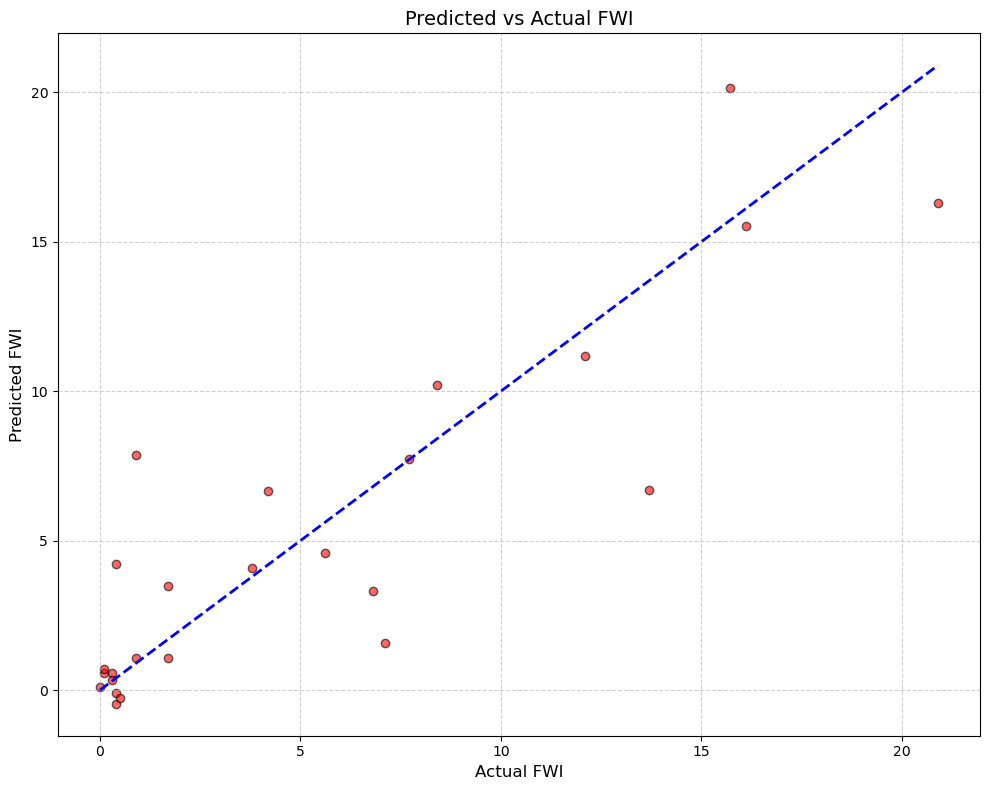

In [ ]:


features = ["Temperature","RH","Ws","Rain","day"]
target = "FWI"

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5),
        "random_state": 42
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=30)
best_xgb_params = study_xgb.best_params
best_xgb_params['random_state'] = 42

xgb_model = xgb.XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, xgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, xgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[I 2025-11-04 21:55:04,290] A new study created in memory with name: no-name-2f05ed58-edc4-43fc-a872-664d29ada19b
c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 1039, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-04 21:55:04,396] Trial 1 finished with value: 3.307965881415999 and parameters: {'n_estimators': 615, 'num_leaves': 198, 'max_depth': 4, 'learning_rate': 0.2631401130522275, 'subsample': 0.8100629580372016, 'colsample_bytree': 0.7525420808934506, 'reg_alpha': 0.18312599439676058, 'reg_lambda': 3.0860326002320946}. Best is trial 0 with value: 3.286951255262474.
[I 2025-11-04 21:55:04,442] Trial 2 finished with value: 3.323372634422827 and parameters: {'n_estimators': 950, 'num_leaves': 112, 'max_depth': 11, 'learning_rate': 0.06667601652971025, 'subsample': 0.7111861792355336, 'colsample_bytree': 0.7606142253739246, 'reg_alpha': 4.483310871184709, 'reg_lambda': 0.20286177419830687}. Best is trial 0 with value: 3.286951255262474.
[I 2025-11-04 21:55:04,462] Trial 3 finished with value: 3.331385498330807 and parameters: {'n_estimators': 209, 'num_leaves': 184, 'max_depth': 5, 'learning_rate': 0.06752336452693156, 'subsample': 0.9996834408730274, 'colsample_bytree': 0.6447211546

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:04,541] Trial 5 finished with value: 3.3372876148980173 and parameters: {'n_estimators': 455, 'num_leaves': 185, 'max_depth': 10, 'learning_rate': 0.12577783156167344, 'subsample': 0.8450127745189757, 'colsample_bytree': 0.8002883272052346, 'reg_alpha': 4.086277822207432, 'reg_lambda': 3.90047299246542}. Best is trial 0 with value: 3.286951255262474.
[I 2025-11-04 21:55:04,555] Trial 6 finished with value: 3.292727357256514 and parameters: {'n_estimators': 158, 'num_leaves': 110, 'max_depth': 7, 'learning_rate': 0.18109438451537516, 'subsample': 0.7029809656472069, 'colsample_bytree': 0.6500911448801767, 'reg_alpha': 0.6605491905350475, 'reg_lambda': 3.2070371134626825}. Best is trial 0 with value: 3.286951255262474.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:04,613] Trial 7 finished with value: 3.2649404495355276 and parameters: {'n_estimators': 447, 'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.11262830759322306, 'subsample': 0.727257019895454, 'colsample_bytree': 0.7703578386606905, 'reg_alpha': 0.8083460938058901, 'reg_lambda': 2.5952694750647893}. Best is trial 7 with value: 3.2649404495355276.
[I 2025-11-04 21:55:04,648] Trial 8 finished with value: 3.196796232099897 and parameters: {'n_estimators': 568, 'num_leaves': 93, 'max_depth': 3, 'learning_rate': 0.06254922947485597, 'subsample': 0.6024707140353452, 'colsample_bytree': 0.6321728133808577, 'reg_alpha': 0.9305701245885017, 'reg_lambda': 0.18448877245203332}. Best is trial 8 with value: 3.196796232099897.
[I 2025-11-04 21:55:04,673] Trial 9 finished with value: 3.4331380119658927 and parameters: {'n_estimators': 612, 'num_leaves': 55, 'max_depth': 9, 'learning_rate': 0.23035042940105263, 'subsample': 0.8866782275760587, 'colsample_bytree': 0.6466296134

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:04,745] Trial 11 finished with value: 3.2464188321958782 and parameters: {'n_estimators': 433, 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.16408357398314805, 'subsample': 0.6144100408045785, 'colsample_bytree': 0.8363738295726628, 'reg_alpha': 1.494739268137121, 'reg_lambda': 2.125951683549198}. Best is trial 8 with value: 3.196796232099897.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:04,782] Trial 12 finished with value: 3.141222855603156 and parameters: {'n_estimators': 402, 'num_leaves': 24, 'max_depth': 14, 'learning_rate': 0.1823554162544875, 'subsample': 0.6040199111005542, 'colsample_bytree': 0.8558323154387261, 'reg_alpha': 1.928423504080342, 'reg_lambda': 1.903483171519015}. Best is trial 12 with value: 3.141222855603156.
[I 2025-11-04 21:55:04,829] Trial 13 finished with value: 3.183301668004768 and parameters: {'n_estimators': 857, 'num_leaves': 74, 'max_depth': 3, 'learning_rate': 0.20852558322341044, 'subsample': 0.6530839386580548, 'colsample_bytree': 0.8819368051378274, 'reg_alpha': 2.6179318780835503, 'reg_lambda': 0.10101497915196278}. Best is trial 12 with value: 3.141222855603156.
[I 2025-11-04 21:55:04,879] Trial 14 finished with value: 3.2503199758063634 and parameters: {'n_estimators': 989, 'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.20969209559945393, 'subsample': 0.6644238593146234, 'colsample_bytree': 0.99456223

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:04,931] Trial 15 finished with value: 3.17989623178229 and parameters: {'n_estimators': 855, 'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.2913241309534592, 'subsample': 0.749367996335905, 'colsample_bytree': 0.8843793642264234, 'reg_alpha': 2.94508095264066, 'reg_lambda': 0.02170427807837423}. Best is trial 12 with value: 3.141222855603156.
[I 2025-11-04 21:55:04,963] Trial 16 finished with value: 3.198967739762302 and parameters: {'n_estimators': 329, 'num_leaves': 20, 'max_depth': 13, 'learning_rate': 0.29302577500760507, 'subsample': 0.7676542677374869, 'colsample_bytree': 0.8957324079350197, 'reg_alpha': 3.129236914884274, 'reg_lambda': 2.5605264127805363}. Best is trial 12 with value: 3.141222855603156.
[I 2025-11-04 21:55:05,007] Trial 17 finished with value: 3.076932939144355 and parameters: {'n_estimators': 807, 'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.2988973936781125, 'subsample': 0.7633134196598046, 'colsample_bytree': 0.845102257078

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:55:05,077] Trial 18 finished with value: 3.1407502113037657 and parameters: {'n_estimators': 704, 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.24834517395525815, 'subsample': 0.9813598233251601, 'colsample_bytree': 0.8250723249464669, 'reg_alpha': 1.9549674142215159, 'reg_lambda': 1.4294911055560071}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:05,142] Trial 19 finished with value: 3.14163390419682 and parameters: {'n_estimators': 738, 'num_leaves': 144, 'max_depth': 15, 'learning_rate': 0.25434031312194133, 'subsample': 0.9713053327227064, 'colsample_bytree': 0.7161691009290867, 'reg_alpha': 1.962044483370193, 'reg_lambda': 1.4439513452913406}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,201] Trial 20 finished with value: 3.2344125902944416 and parameters: {'n_estimators': 833, 'num_leaves': 50, 'max_depth': 12, 'learning_rate': 0.2595350666484469, 'subsample': 0.9119992551250309, 'colsample_bytree': 0.8192059548927992, 'reg_alpha': 2.2782348736489744, 'reg_lambda': 0.77818404657701}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:55:05,266] Trial 21 finished with value: 3.262400481146507 and parameters: {'n_estimators': 706, 'num_leaves': 45, 'max_depth': 14, 'learning_rate': 0.22993404038678275, 'subsample': 0.7943799871916879, 'colsample_bytree': 0.8499085125204401, 'reg_alpha': 1.440165020863047, 'reg_lambda': 1.9983140584361303}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,307] Trial 22 finished with value: 3.2806000999543086 and parameters: {'n_estimators': 495, 'num_leaves': 73, 'max_depth': 15, 'learning_rate': 0.29848361058397727, 'subsample': 0.9439373526346096, 'colsample_bytree': 0.9410062003608798, 'reg_alpha': 1.4981638577025016, 'reg_lambda': 1.2242017848667532}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:05,342] Trial 23 finished with value: 3.1219329462903755 and parameters: {'n_estimators': 337, 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.18809693115445458, 'subsample': 0.8243874599847641, 'colsample_bytree': 0.8404636717953928, 'reg_alpha': 2.093230724028138, 'reg_lambda': 1.711159530738601}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,374] Trial 24 finished with value: 3.318526120262755 and parameters: {'n_estimators': 104, 'num_leaves': 40, 'max_depth': 12, 'learning_rate': 0.27107791050221264, 'subsample': 0.846184532643534, 'colsample_bytree': 0.7858266126628719, 'reg_alpha': 2.328728441618726, 'reg_lambda': 0.6459868998596452}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,423] Trial 25 finished with value: 3.3259096297668758 and parameters: {'n_estimators': 648, 'num_leaves': 60, 'max_depth': 13, 'learning_rate': 0.22983803562188784, 'subsample': 0.8330043033766632, 'colsample_bytree': 0.81161080

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:05,476] Trial 26 finished with value: 3.2883062186185184 and parameters: {'n_estimators': 812, 'num_leaves': 95, 'max_depth': 11, 'learning_rate': 0.14042528551285172, 'subsample': 0.7732304363702702, 'colsample_bytree': 0.9229732589480677, 'reg_alpha': 3.2418585500552903, 'reg_lambda': 2.3097742722412065}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:05,536] Trial 27 finished with value: 3.177716910252729 and parameters: {'n_estimators': 911, 'num_leaves': 68, 'max_depth': 8, 'learning_rate': 0.20330552459770837, 'subsample': 0.9335984251133715, 'colsample_bytree': 0.7408234583487643, 'reg_alpha': 2.2654886899566575, 'reg_lambda': 3.0978577195420054}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,575] Trial 28 finished with value: 3.2622467913561493 and parameters: {'n_estimators': 304, 'num_leaves': 83, 'max_depth': 14, 'learning_rate': 0.24481858669754342, 'subsample': 0.8720556318381443, 'colsample_bytree': 0.8538242270157602, 'reg_alpha': 0.2747683647482153, 'reg_lambda': 1.0275526000154205}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,614] Trial 29 finished with value: 3.2713776470224105 and parameters: {'n_estimators': 526, 'num_leaves': 140, 'max_depth': 11, 'learning_rate': 0.279611854830057, 'subsample': 0.8016363353206163, 'colsample_bytree': 0.915367

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:05,675] Trial 30 finished with value: 3.291562981661987 and parameters: {'n_estimators': 789, 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.1619428818303369, 'subsample': 0.9984319993779326, 'colsample_bytree': 0.9737028316243936, 'reg_alpha': 1.1527300093856352, 'reg_lambda': 1.3981116719623883}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,748] Trial 31 finished with value: 3.1290755627455007 and parameters: {'n_estimators': 396, 'num_leaves': 33, 'max_depth': 14, 'learning_rate': 0.18772860116584303, 'subsample': 0.9151543082530282, 'colsample_bytree': 0.8616885729758748, 'reg_alpha': 1.9896958405645575, 'reg_lambda': 1.8064627163344993}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from scor

[I 2025-11-04 21:55:05,807] Trial 32 finished with value: 3.1554973899957384 and parameters: {'n_estimators': 379, 'num_leaves': 34, 'max_depth': 15, 'learning_rate': 0.19540214708860404, 'subsample': 0.9658710510847794, 'colsample_bytree': 0.823749615111543, 'reg_alpha': 2.068356909214875, 'reg_lambda': 0.4608625319953902}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,848] Trial 33 finished with value: 3.223450515456318 and parameters: {'n_estimators': 262, 'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.1459964340327384, 'subsample': 0.9002001880288814, 'colsample_bytree': 0.8647268205058704, 'reg_alpha': 2.6023153765319953, 'reg_lambda': 1.6909448690048374}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:05,887] Trial 34 finished with value: 3.1748584689164545 and parameters: {'n_estimators': 623, 'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.24566879448033455, 'subsample': 0.936840230202906, 'colsample_bytree': 0.7934782306194954, 'reg_alpha': 4.978465437973184, 'reg_lambda': 2.6788064049941602}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:05,920] Trial 35 finished with value: 3.1878187055977674 and parameters: {'n_estimators': 242, 'num_leaves': 34, 'max_depth': 13, 'learning_rate': 0.27540421201520904, 'subsample': 0.970159950802052, 'colsample_bytree': 0.8305806661406941, 'reg_alpha': 1.6683527775564457, 'reg_lambda': 1.1960580296100067}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:05,969] Trial 36 finished with value: 3.167752718471757 and parameters: {'n_estimators': 663, 'num_leaves': 88, 'max_depth': 10, 'learning_rate': 0.18029831408450847, 'subsample': 0.8701645421963825, 'colsample_bytree': 0.7451027026463037, 'reg_alpha': 2.3465122220435513, 'reg_lambda': 2.187010552548217}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,027] Trial 37 finished with value: 3.3197573113726095 and parameters: {'n_estimators': 574, 'num_leaves': 50, 'max_depth': 15, 'learning_rate': 0.22617240596508698, 'subsample': 0.8233625156285526, 'colsample_bytree': 0.9153493448618564, 'reg_alpha': 3.370132349860203, 'reg_lambda': 3.606857181591235}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,132] Trial 38 finished with value: 3.2350684135424617 and parameters: {'n_estimators': 898, 'num_leaves': 121, 'max_depth': 6, 'learning_rate': 0.10062320678932347, 'subsample': 0.7212158027070406, 'colsample_bytree': 0.776067660890081, 'reg_alpha': 2.8477029354345955, 'reg_lambda': 0.5806377853971709}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,194] Trial 39 finished with value: 3.3059077040633698 and parameters: {'n_estimators': 697, 'num_leaves': 162, 'max_depth': 11, 'learning_rate': 0.2195666173386433, 'subsample': 0.9128297220577836, 'colsample_bytree': 0.8684828912728059, 'reg_alpha': 1.0849297684885646, 'reg_lambda': 2.808754383404939}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:06,249] Trial 40 finished with value: 3.1707645698865554 and parameters: {'n_estimators': 492, 'num_leaves': 66, 'max_depth': 14, 'learning_rate': 0.12956206242004875, 'subsample': 0.9971117128494731, 'colsample_bytree': 0.7983960687354611, 'reg_alpha': 0.45157110604101236, 'reg_lambda': 1.8126649289015155}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,295] Trial 41 finished with value: 3.1337731418973314 and parameters: {'n_estimators': 376, 'num_leaves': 26, 'max_depth': 14, 'learning_rate': 0.18878705057188983, 'subsample': 0.6354968642531849, 'colsample_bytree': 0.8450277346447985, 'reg_alpha': 2.0888429755399938, 'reg_lambda': 1.394348565694318}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,334] Trial 42 finished with value: 3.1346565048295965 and parameters: {'n_estimators': 355, 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.1847673103307696, 'subsample': 0.6913144470397421, 'colsample_bytree': 0.8295038003437363, 'reg_alpha': 2.1287434574440756, 'reg_lambda': 1.4754314061996947}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,372] Trial 43 finished with value: 3.1911112570579654 and parameters: {'n_estimators': 382, 'num_leaves': 26, 'max_depth': 12, 'learning_rate': 0.18705576025324783, 'subsample': 0.6892545117497515, 'colsample_bytree': 0.87441

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,435] Trial 45 finished with value: 3.252040667103993 and parameters: {'n_estimators': 340, 'num_leaves': 28, 'max_depth': 11, 'learning_rate': 0.1518101001940881, 'subsample': 0.739344660313943, 'colsample_bytree': 0.8433771448849888, 'reg_alpha': 2.558846174201522, 'reg_lambda': 0.4356217876736004}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,468] Trial 46 finished with value: 3.2273203080119903 and parameters: {'n_estimators': 262, 'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.16931770514457978, 'subsample': 0.6980585657510119, 'colsample_bytree': 0.8049756279339868, 'reg_alpha': 1.3588326787362044, 'reg_lambda': 0.9668676581795697}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,514] Trial 47 finished with value: 3.291050556975336 and parameters: {'n_estimators': 453, 'num_leaves': 31, 'max_depth': 14, 'learning_rate': 0.11728143352166004, 'subsample': 0.6253183952758549, 'colsample_bytree': 0.84247774

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:06,565] Trial 48 finished with value: 3.311128060427196 and parameters: {'n_estimators': 412, 'num_leaves': 56, 'max_depth': 12, 'learning_rate': 0.07849349807884508, 'subsample': 0.6729115443545055, 'colsample_bytree': 0.7692594776176672, 'reg_alpha': 1.7173172499397202, 'reg_lambda': 2.0749144831858213}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,603] Trial 49 finished with value: 3.1561717582861495 and parameters: {'n_estimators': 349, 'num_leaves': 21, 'max_depth': 10, 'learning_rate': 0.2015987909594995, 'subsample': 0.6451749189608059, 'colsample_bytree': 0.8667958371141772, 'reg_alpha': 2.432664827686345, 'reg_lambda': 1.7922276987038728}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,637] Trial 50 finished with value: 3.213574994451332 and parameters: {'n_estimators': 287, 'num_leaves': 29, 'max_depth': 9, 'learning_rate': 0.19005811959228613, 'subsample': 0.7697455560837292, 'colsample_bytree': 0.6797931784924605, 'reg_alpha': 0.7442544708512149, 'reg_lambda': 0.81191185840585}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,693] Trial 51 finished with value: 3.2117552617419727 and parameters: {'n_estimators': 369, 'num_leaves': 49, 'max_depth': 15, 'learning_rate': 0.21815597803293038, 'subsample': 0.7138699520363847, 'colsample_bytree': 0.8254794896845995, 'reg_alpha': 2.040009561012757, 'reg_lambda': 1.3903470292061}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,722] Trial 52 finished with value: 3.262067092207106 and parameters: {'n_estimators': 221, 'num_leaves': 55, 'max_depth': 14, 'learning_rate': 0.160225239584739, 'subsample': 0.626864779496019, 'colsample_bytree': 0.605283934160376

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,780] Trial 53 finished with value: 3.2006920505413263 and parameters: {'n_estimators': 422, 'num_leaves': 37, 'max_depth': 15, 'learning_rate': 0.2413260739801299, 'subsample': 0.7896391281550764, 'colsample_bytree': 0.8364421396985613, 'reg_alpha': 1.6204049060537549, 'reg_lambda': 1.4706232201698093}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:06,828] Trial 54 finished with value: 3.208573723202343 and parameters: {'n_estimators': 487, 'num_leaves': 46, 'max_depth': 13, 'learning_rate': 0.21442623332811384, 'subsample': 0.7517360364181368, 'colsample_bytree': 0.891904265624006, 'reg_alpha': 1.8698251708687734, 'reg_lambda': 1.883752850851398}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:06,870] Trial 55 finished with value: 3.161127282322885 and parameters: {'n_estimators': 546, 'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.28504800188291046, 'subsample': 0.8587124637838466, 'colsample_bytree': 0.8157517329826778, 'reg_alpha': 2.946820744970932, 'reg_lambda': 4.466859506020485}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:06,948] Trial 56 finished with value: 3.1206228611919498 and parameters: {'n_estimators': 774, 'num_leaves': 39, 'max_depth': 15, 'learning_rate': 0.25869809657176307, 'subsample': 0.6939571418637003, 'colsample_bytree': 0.8496051690037971, 'reg_alpha': 2.470854589089914, 'reg_lambda': 0.926748382036793}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,001] Trial 57 finished with value: 3.262074385500631 and parameters: {'n_estimators': 293, 'num_leaves': 38, 'max_depth': 13, 'learning_rate': 0.26683453805100626, 'subsample': 0.6854952131147165, 'colsample_bytree': 0.8626634748247065, 'reg_alpha': 2.7001086979304687, 'reg_lambda': 0.36716337301989954}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:07,058] Trial 58 finished with value: 3.0951257968480537 and parameters: {'n_estimators': 777, 'num_leaves': 61, 'max_depth': 14, 'learning_rate': 0.19911979197593505, 'subsample': 0.7315779298436468, 'colsample_bytree': 0.8807975863926386, 'reg_alpha': 2.4179711487393956, 'reg_lambda': 0.9385200830226756}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,144] Trial 59 finished with value: 3.204751094416408 and parameters: {'n_estimators': 907, 'num_leaves': 190, 'max_depth': 14, 'learning_rate': 0.17378261509027568, 'subsample': 0.7482945453300965, 'colsample_bytree': 0.8789307000268287, 'reg_alpha': 3.001744366090797, 'reg_lambda': 0.92772162563971}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:07,208] Trial 60 finished with value: 3.1880730976169533 and parameters: {'n_estimators': 861, 'num_leaves': 77, 'max_depth': 15, 'learning_rate': 0.2599358035949693, 'subsample': 0.7259031917900621, 'colsample_bytree': 0.9356401872259006, 'reg_alpha': 2.5461436656933065, 'reg_lambda': 0.7279510971092502}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,270] Trial 61 finished with value: 3.1529814291915805 and parameters: {'n_estimators': 765, 'num_leaves': 60, 'max_depth': 14, 'learning_rate': 0.19639285381465063, 'subsample': 0.7070118641344214, 'colsample_bytree': 0.8517877599202004, 'reg_alpha': 2.2001597641713104, 'reg_lambda': 1.2948092338415658}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-11-04 21:55:07,345] Trial 62 finished with value: 3.2922140358234904 and parameters: {'n_estimators': 763, 'num_leaves': 20, 'max_depth': 13, 'learning_rate': 0.18371692622914448, 'subsample': 0.6577849954808146, 'colsample_bytree': 0.9036847072246322, 'reg_alpha': 2.411653400671905, 'reg_lambda': 1.055235644771236}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:07,417] Trial 63 finished with value: 3.2366169911601355 and parameters: {'n_estimators': 730, 'num_leaves': 32, 'max_depth': 12, 'learning_rate': 0.20924462986949152, 'subsample': 0.7348839940144118, 'colsample_bytree': 0.8802970432631281, 'reg_alpha': 2.769791792160552, 'reg_lambda': 1.602590902543515}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:07,508] Trial 64 finished with value: 3.252896689682037 and parameters: {'n_estimators': 987, 'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.13839985781920214, 'subsample': 0.7801970414000845, 'colsample_bytree': 0.8403280547967307, 'reg_alpha': 2.1161631085960253, 'reg_lambda': 0.8601486322863985}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,567] Trial 65 finished with value: 3.2668230651727055 and parameters: {'n_estimators': 810, 'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.19485218491508272, 'subsample': 0.812862758522369, 'colsample_bytree': 0.855490094663876, 'reg_alpha': 1.5525703315470452, 'reg_lambda': 0.20837114710837634}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:07,605] Trial 66 finished with value: 3.179953886128171 and parameters: {'n_estimators': 315, 'num_leaves': 26, 'max_depth': 15, 'learning_rate': 0.23674444816720658, 'subsample': 0.6732180111264, 'colsample_bytree': 0.8175910935353646, 'reg_alpha': 1.823234456762851, 'reg_lambda': 1.7262745103891621}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,677] Trial 67 finished with value: 3.3847570257118464 and parameters: {'n_estimators': 392, 'num_leaves': 103, 'max_depth': 13, 'learning_rate': 0.028865483113123397, 'subsample': 0.7395413222386288, 'colsample_bytree': 0.8072162972574582, 'reg_alpha': 1.9639773311481123, 'reg_lambda': 1.9766243493735312}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,718] Trial 68 finished with value: 3.177849819320383 and parameters: {'n_estimators': 469, 'num_leaves': 50, 'max_depth': 12, 'learning_rate': 0.2959120047070395, 'subsample': 0.7541051949674309, 'colsample_bytree': 0.88916078

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:07,775] Trial 69 finished with value: 3.285399672074976 and parameters: {'n_estimators': 584, 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.25424326538579256, 'subsample': 0.7024019516146871, 'colsample_bytree': 0.7903703544165417, 'reg_alpha': 1.3687011700164866, 'reg_lambda': 4.991600530951104}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:07,851] Trial 70 finished with value: 3.204299151880193 and parameters: {'n_estimators': 360, 'num_leaves': 122, 'max_depth': 15, 'learning_rate': 0.15772406229160793, 'subsample': 0.7143379081019914, 'colsample_bytree': 0.8326921014226761, 'reg_alpha': 2.28495999891047, 'reg_lambda': 1.545221959756167}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:07,941] Trial 71 finished with value: 3.2544604758196716 and parameters: {'n_estimators': 795, 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.2814352204580805, 'subsample': 0.9579239083438198, 'colsample_bytree': 0.8492120338667531, 'reg_alpha': 1.99008964003537, 'reg_lambda': 0.6009483407125356}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-04 21:55:08,012] Trial 72 finished with value: 3.2453008372105345 and parameters: {'n_estimators': 688, 'num_leaves': 61, 'max_depth': 14, 'learning_rate': 0.20486237779812186, 'subsample': 0.6889426271938415, 'colsample_bytree': 0.8259028587155126, 'reg_alpha': 1.780135511694327, 'reg_lambda': 1.0686491913922973}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,063] Trial 73 finished with value: 3.1696377836498937 and parameters: {'n_estimators': 723, 'num_leaves': 73, 'max_depth': 15, 'learning_rate': 0.2236691229208707, 'subsample': 0.9221685974547206, 'colsample_bytree': 0.8613108668683693, 'reg_alpha': 2.505438992140485, 'reg_lambda': 1.3154337034893497}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,118] Trial 74 finished with value: 3.1763930141488523 and parameters: {'n_estimators': 661, 'num_leaves': 44, 'max_depth': 14, 'learning_rate': 0.17992541584677318, 'subsample': 0.982678710922226, 'colsample_bytree': 0.7808417

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:08,257] Trial 76 finished with value: 3.1917060329723954 and parameters: {'n_estimators': 891, 'num_leaves': 52, 'max_depth': 15, 'learning_rate': 0.19149040884222407, 'subsample': 0.7578654011247582, 'colsample_bytree': 0.8069113933133284, 'reg_alpha': 2.6977931575046465, 'reg_lambda': 1.6788552872817109}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,308] Trial 77 finished with value: 3.257714645306406 and parameters: {'n_estimators': 517, 'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.233298118414084, 'subsample': 0.8960074545940422, 'colsample_bytree': 0.7625040780752445, 'reg_alpha': 1.2517110857756855, 'reg_lambda': 1.1946403847833111}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,365] Trial 78 finished with value: 3.2701706665571013 and parameters: {'n_estimators': 785, 'num_leaves': 25, 'max_depth': 7, 'learning_rate': 0.16761601043231253, 'subsample': 0.8778499959201044, 'colsample_bytree': 0.9070542

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:55:08,436] Trial 79 finished with value: 3.24795942955554 and parameters: {'n_estimators': 870, 'num_leaves': 164, 'max_depth': 13, 'learning_rate': 0.27117085423867265, 'subsample': 0.6153699753011463, 'colsample_bytree': 0.8431728007863001, 'reg_alpha': 0.9592889315929095, 'reg_lambda': 0.709055571232047}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:08,500] Trial 80 finished with value: 3.1410347664998333 and parameters: {'n_estimators': 431, 'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.29017234508457196, 'subsample': 0.7839582152820938, 'colsample_bytree': 0.8312494901509615, 'reg_alpha': 2.0639407871233586, 'reg_lambda': 2.079205753738551}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,543] Trial 81 finished with value: 3.1469408927245723 and parameters: {'n_estimators': 338, 'num_leaves': 41, 'max_depth': 14, 'learning_rate': 0.2867596207712288, 'subsample': 0.7819382179023385, 'colsample_bytree': 0.8325477513153157, 'reg_alpha': 2.0659114625092014, 'reg_lambda': 2.1419324508376025}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,582] Trial 82 finished with value: 3.2221752331966558 and parameters: {'n_estimators': 438, 'num_leaves': 48, 'max_depth': 15, 'learning_rate': 0.2996863833077102, 'subsample': 0.8016739503847219, 'colsample_bytree': 0.818420

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:08,624] Trial 83 finished with value: 3.114164629519477 and parameters: {'n_estimators': 402, 'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.2777623192437844, 'subsample': 0.8373462714174067, 'colsample_bytree': 0.8549210549433219, 'reg_alpha': 2.3288004542029013, 'reg_lambda': 2.4440895837691983}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:55:08,684] Trial 84 finished with value: 3.1988182068019726 and parameters: {'n_estimators': 399, 'num_leaves': 29, 'max_depth': 13, 'learning_rate': 0.27181176757133907, 'subsample': 0.8355737143204249, 'colsample_bytree': 0.8712994473544087, 'reg_alpha': 2.458683351231012, 'reg_lambda': 2.5589688491007028}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,726] Trial 85 finished with value: 3.1194872114236425 and parameters: {'n_estimators': 274, 'num_leaves': 35, 'max_depth': 15, 'learning_rate': 0.20062040720308078, 'subsample': 0.8178921970127647, 'colsample_bytree': 0.8526655623216349, 'reg_alpha': 2.2989853456649447, 'reg_lambda': 1.8438813114273083}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,758] Trial 86 finished with value: 3.2758961390867984 and parameters: {'n_estimators': 148, 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.17503353316456244, 'subsample': 0.8195283598950244, 'colsample_bytree': 0.8562

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:55:08,832] Trial 88 finished with value: 3.205894099765487 and parameters: {'n_estimators': 269, 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.20337079671764527, 'subsample': 0.8372683595170316, 'colsample_bytree': 0.8480380697760059, 'reg_alpha': 2.829531455420509, 'reg_lambda': 2.8597327239250703}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:08,884] Trial 89 finished with value: 3.2031961736081187 and parameters: {'n_estimators': 229, 'num_leaves': 24, 'max_depth': 14, 'learning_rate': 0.1855628234170168, 'subsample': 0.8238740248975823, 'colsample_bytree': 0.8607500037774938, 'reg_alpha': 2.56687661468259, 'reg_lambda': 1.8232745189657296}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:08,936] Trial 90 finished with value: 3.2214205573105517 and parameters: {'n_estimators': 204, 'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.20055937623405182, 'subsample': 0.7645171766485167, 'colsample_bytree': 0.8962131322873115, 'reg_alpha': 3.279106667760936, 'reg_lambda': 1.730414915120144}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:09,039] Trial 91 finished with value: 3.2064552207264776 and parameters: {'n_estimators': 813, 'num_leaves': 58, 'max_depth': 15, 'learning_rate': 0.15162248066470901, 'subsample': 0.8485585447341801, 'colsample_bytree': 0.870068274162475, 'reg_alpha': 2.178593107874758, 'reg_lambda': 1.3726141833157044}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:09,090] Trial 92 finished with value: 3.2062015243062283 and parameters: {'n_estimators': 356, 'num_leaves': 37, 'max_depth': 14, 'learning_rate': 0.2553455587933625, 'subsample': 0.8072310715510773, 'colsample_bytree': 0.796984081344211, 'reg_alpha': 2.3698386451546463, 'reg_lambda': 1.540296652868288}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:09,136] Trial 93 finished with value: 3.278729803911884 and parameters: {'n_estimators': 284, 'num_leaves': 33, 'max_depth': 15, 'learning_rate': 0.2621244709186138, 'subsample': 0.7934285803092415, 'colsample_bytree': 0.8397323166646107, 'reg_alpha': 1.866139051176278, 'reg_lambda': 1.073635281331174}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:09,189] Trial 94 finished with value: 3.181526742118826 and parameters: {'n_estimators': 753, 'num_leaves': 54, 'max_depth': 14, 'learning_rate': 0.23971667953447426, 'subsample': 0.6958732615975844, 'colsample_bytree': 0.8227833438304974, 'reg_alpha': 1.699774242548625, 'reg_lambda': 1.6283957467731258}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:09,237] Trial 95 finished with value: 3.1966013681829506 and parameters: {'n_estimators': 382, 'num_leaves': 28, 'max_depth': 13, 'learning_rate': 0.28168693391681715, 'subsample': 0.663479648208129, 'colsample_bytree': 0.8481664469

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:09,311] Trial 96 finished with value: 3.1587299657289214 and parameters: {'n_estimators': 409, 'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.1762707921273289, 'subsample': 0.7205688718529051, 'colsample_bytree': 0.8810184982241032, 'reg_alpha': 1.9522052897913942, 'reg_lambda': 1.8642244382507036}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:55:09,380] Trial 97 finished with value: 3.1798769798351003 and parameters: {'n_estimators': 826, 'num_leaves': 47, 'max_depth': 15, 'learning_rate': 0.27598280157252625, 'subsample': 0.9818302647330719, 'colsample_bytree': 0.8609083303942093, 'reg_alpha': 2.2850596233574403, 'reg_lambda': 1.4323248781319315}. Best is trial 17 with value: 3.076932939144355.
[I 2025-11-04 21:55:09,467] Trial 98 finished with value: 3.2588689082345508 and parameters: {'n_estimators': 710, 'num_leaves': 41, 'max_depth': 14, 'learning_rate': 0.22056778787746872, 'subsample': 0.6344020641205446, 'colsample_bytree': 0.8097712407827409, 'reg_alpha': 2.1501927629422806, 'reg_lambda': 2.2279252407373757}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:55:09,523] Trial 99 finished with value: 3.1789104693200656 and parameters: {'n_estimators': 466, 'num_leaves': 37, 'max_depth': 8, 'learning_rate': 0.16543133899261822, 'subsample': 0.883539748151358, 'colsample_bytree': 0.8272886691906314, 'reg_alpha': 2.46705365066487, 'reg_lambda': 0.8188928041935427}. Best is trial 17 with value: 3.076932939144355.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 5
[LightGBM] [Info] Start training from score 5.677320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


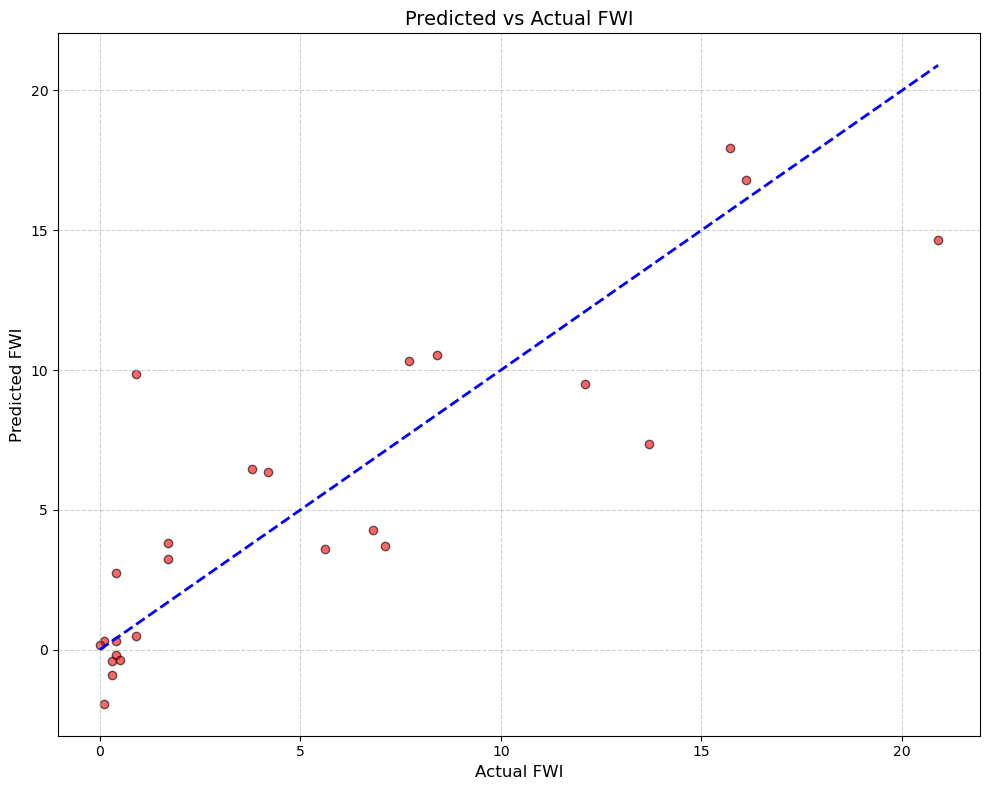

In [ ]:

def lgb_objective(trial): #objective function is defined for hyperparameter tuning 
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=False),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42
    }
    
    model = lgb.LGBMRegressor(**params)  #initially the model is trained for the above sample hyperparameters
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_lgb = optuna.create_study(direction='minimize') # the hyperparameter optimisation is run for 100 trials
study_lgb.optimize(lgb_objective, n_trials=100)
best_lgb_params = study_lgb.best_params
best_lgb_params['random_state'] = 42

lgb_model = lgb.LGBMRegressor(**best_lgb_params) #the best hyperparameters and the used to train the final Light GBM model
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM R²:", r2_score(y_test, lgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, lgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/


Random Forest Regressor 

[I 2025-11-04 21:55:09,764] A new study created in memory with name: no-name-00eb6590-540c-40cf-a956-2c47ecb1d6b8


[I 2025-11-04 21:55:10,559] Trial 0 finished with value: 3.4628611734246846 and parameters: {'n_estimators': 794, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 0 with value: 3.4628611734246846.
[I 2025-11-04 21:55:10,720] Trial 1 finished with value: 3.459137242484445 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 1 with value: 3.459137242484445.
[I 2025-11-04 21:55:11,366] Trial 2 finished with value: 3.476344408559823 and parameters: {'n_estimators': 646, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 1 with value: 3.459137242484445.
[I 2025-11-04 21:55:11,509] Trial 3 finished with value: 3.667124685829625 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 8}. Best is trial 1 with value: 3.459137242484445.
[I 2025-11-04 21:55:12,067] Trial 4 finished with value: 3.3561343822343925 and parameters: {'n_

Random Forest R²: 0.6988580754897699


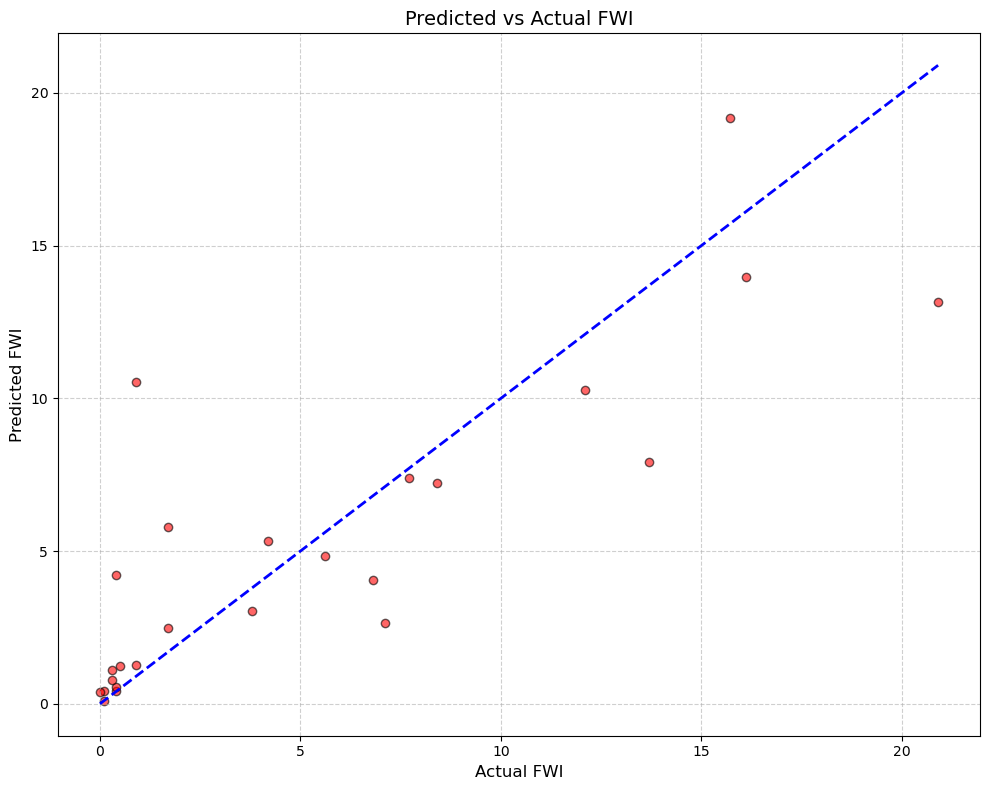

In [ ]:

def rf_objective(trial): #objective function for Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000), #total number of trees in the forest
        "max_depth": trial.suggest_int("max_depth", 3, 15), #maximum depth of each decision tree
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1 #uses all CPU cores for faster computaiton
    }
    
    model = RandomForestRegressor(**params)   #random forest model is trained 
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_rf = optuna.create_study(direction='minimize')  #Optuna hyperparameter optimisation is conducted 
study_rf.optimize(rf_objective, n_trials=100)
best_rf_params = study_rf.best_params
best_rf_params['random_state'] = 42
best_rf_params['n_jobs'] = -1

rf_model = RandomForestRegressor(**best_rf_params)  #using best parameters the model is then trained 
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, rf_preds))


plt.figure(figsize=(10, 8))
plt.scatter(y_test, rf_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://medium.com/@ehsannabatchian/optimizing-random-forest-models-a-deep-dive-into-hyperparameter-tuning-with-optuna-b8e4fe7f3670